In [20]:
import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sqlalchemy import create_engine

In [21]:
engine = create_engine("mssql+pyodbc://@NovaNexus/AdventureWorks2022?Trusted_Connection=yes&driver=ODBC+Driver+17+for+SQL+Server")


In [22]:
connection = engine.connect()

## Human Resources - AdventureWorks 2022


In [23]:
#Kollar på avdelningar och antal medarbetare för att få en inblick av struktur till företaget.
AntalAnställdaAvdelningar = """
SELECT 
    D.Name AS Avdelning
    , COUNT(E.BusinessEntityID) AS [Antal Anställda]

FROM HumanResources.Department AS D
		INNER JOIN HumanResources.EmployeeDepartmentHistory AS EDH
			ON D.DepartmentID = EDH.DepartmentID

                INNER JOIN HumanResources.Employee AS E
                    ON E.BusinessEntityID = EDH.BusinessEntityID

WHERE 
	 E.CurrentFlag = 1 AND       --Endast nuvarande medarbetare
     EDH.EndDate IS NULL   --Vill bara inkludera nuvarande medarbetare om dem är kvar i avdelningen

GROUP BY 
    D.[Name]
;
"""
AntalAnställdaAvdelningar = pd.read_sql(AntalAnställdaAvdelningar, engine)
AntalAnställdaAvdelningar

,Avdelning,Antal Anställda
0,Document Control,5
1,Engineering,6
2,Executive,2
3,Facilities and Maintenance,7
4,Finance,10
5,Human Resources,6
6,Information Services,10
7,Marketing,9
8,Production,179
9,Production Control,6


In [24]:
# Fortsätter kolla på avdelningar och var i världen dem finns för att se var och hur företaget ligger.
AvdelningStat = """
WITH DistinctStateAvdelning AS 
(
    SELECT DISTINCT 
        D.[Name] AS Avdelning
        , SP.[Name] AS StateProvins
    
	FROM Person.BusinessEntityAddress AS BEA
			INNER JOIN Person.Address AS A 
				ON BEA.AddressID = A.AddressID
				
				INNER JOIN Person.StateProvince AS SP 
					ON A.StateProvinceID = SP.StateProvinceID
    
					INNER JOIN HumanResources.EmployeeDepartmentHistory AS EDH 
						ON BEA.BusinessEntityID = EDH.BusinessEntityID

						INNER JOIN HumanResources.Employee AS E 
							ON EDH.BusinessEntityID = E.BusinessEntityID
    
							INNER JOIN HumanResources.Department AS D 
								ON EDH.DepartmentID = D.DepartmentID
    
	WHERE E.CurrentFlag = 1
)

SELECT 
    Avdelning
    , StateProvins AS [State or Provins]
FROM 
    DistinctStateAvdelning
ORDER BY 
    Avdelning, StateProvins
;
"""
AvdelningStat = pd.read_sql(AvdelningStat, engine)
AvdelningStat

,Avdelning,State or Provins
0,Document Control,Washington
1,Engineering,Minnesota
2,Engineering,Washington
3,Executive,Washington
4,Facilities and Maintenance,Washington
5,Finance,Washington
6,Human Resources,Washington
7,Information Services,Washington
8,Marketing,Washington
9,Production,Washington


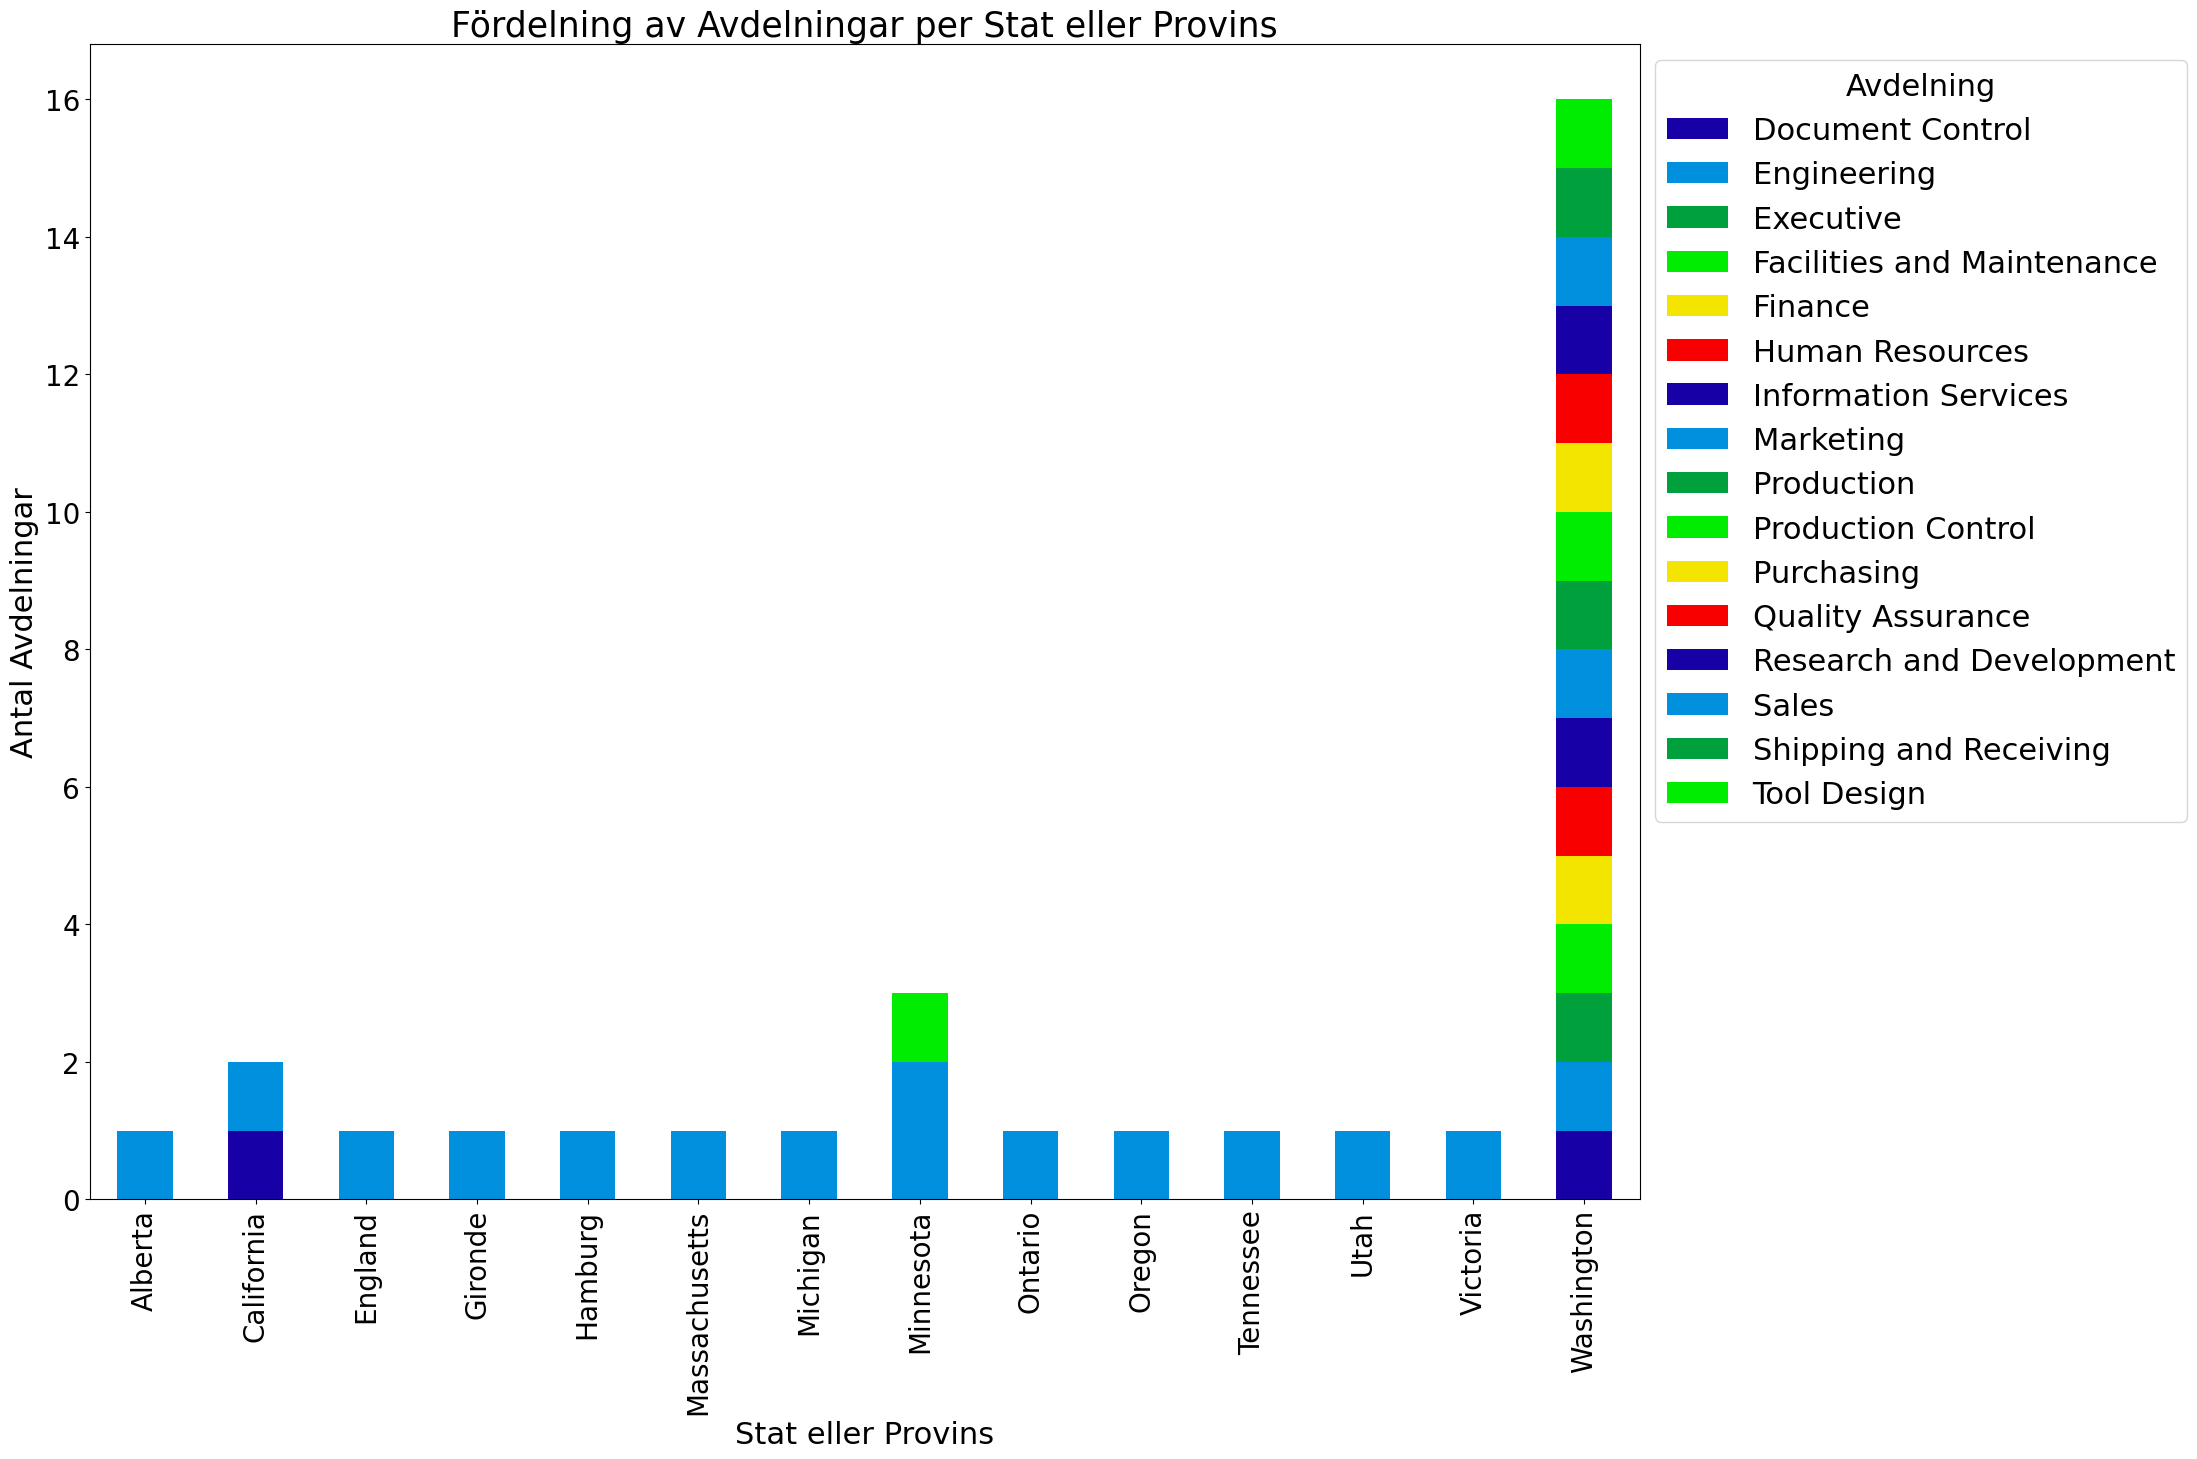

In [25]:
# Skapa visuell för att se hur företaget ser ut geografiskt genom att groupera avdelningen

df = pd.DataFrame(AvdelningStat)

sns.set_palette('nipy_spectral')

AvdelningStat = df.groupby(['State or Provins', 'Avdelning']).size().unstack()
AvdelningStat.plot(kind='bar', stacked=True, figsize=(20, 15))
plt.title('Fördelning av Avdelningar per Stat eller Provins', fontsize=25)

plt.xlabel('Stat eller Provins', fontsize=22)
plt.xticks(fontsize=20)

plt.ylabel('Antal Avdelningar', fontsize=22)
plt.yticks(fontsize=20)

legend = plt.legend(title='Avdelning', bbox_to_anchor=(1, 1), loc='upper left', fontsize=22)
legend.get_title().set_fontsize(22)

plt.show()
 




In [26]:
# Kolla på hierarkin översikt över hur många direkt underordnade varje chef har
# använda left join för att behålla hierarkin
# joina tabelen mot sig själv eftersom informationen är i samma tabell
# GetAncestor hämta organizationNode innan med början 1

Hierarkin = """

   SELECT 
        Chef.OrganizationLevel AS [Organization Nivå]
        , Chef.BusinessEntityID AS [Anställnings ID]
        , Chef.JobTitle AS [Chef Titel]
        , COUNT(E.BusinessEntityID) AS [Antal Direkt Anställda]
    FROM 
        HumanResources.Employee AS E
    LEFT JOIN HumanResources.Employee AS Chef
        ON E.OrganizationNode.GetAncestor(1) = Chef.OrganizationNode
    
    GROUP BY 
        Chef.OrganizationLevel
        , Chef.BusinessEntityID
        , Chef.JobTitle
    ORDER BY 
        Chef.OrganizationLevel, 
        COUNT(E.BusinessEntityID) DESC
;
"""

Hierarkin = pd.read_sql(Hierarkin, engine)
Hierarkin


,Organization Nivå,Anställnings ID,Chef Titel,Antal Direkt Anställda
0,NaN,NaN,None,7
1,1.0,16.0,Marketing Manager,8
2,1.0,263.0,Information Services Manager,7
3,1.0,25.0,Vice President of Production,4
4,1.0,234.0,Chief Financial Officer,4
5,1.0,273.0,Vice President of Sales,3
6,1.0,2.0,Vice President of Engineering,1
7,2.0,26.0,Production Control Manager,22
8,2.0,274.0,North American Sales Manager,10
9,2.0,241.0,Accounts Manager,7


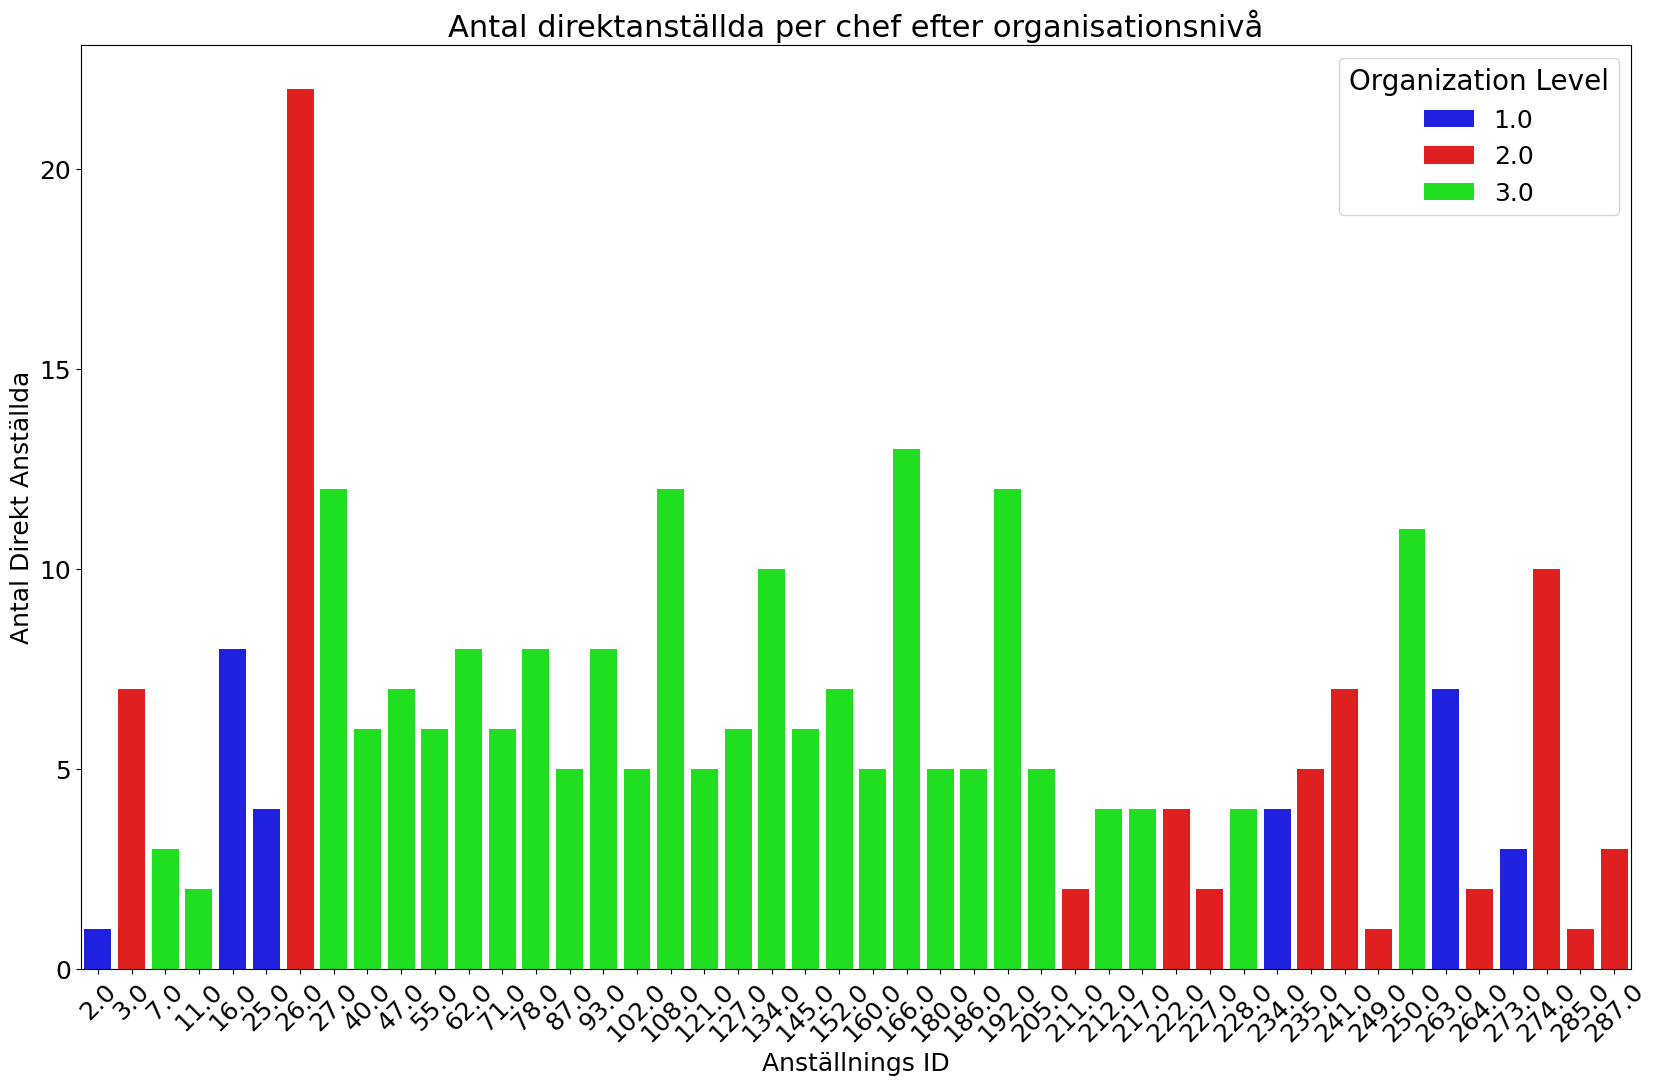

In [27]:
# Visulisera antal chefer i företaget. Behövs det en omstrukturering?

plt.figure(figsize=(20, 12))
sns.barplot(x='Anställnings ID', y='Antal Direkt Anställda', hue='Organization Nivå', 
            data=Hierarkin, palette="brg")
plt.title('Antal direktanställda per chef efter organisationsnivå', fontsize = 22)

plt.xlabel('Anställnings ID', fontsize = 18)
plt.xticks(rotation=45, fontsize = 18)

plt.ylabel('Antal Direkt Anställda', fontsize = 18)
plt.yticks(fontsize = 18)

legend = plt.legend(title='Organization Level', fontsize = 18)
legend.get_title().set_fontsize(20)

plt.show()


In [28]:
# Titta på anställningar per år, har företaget växt under någon period?

ÅrAktivaAnställda = """
    -- Distinkt anställd år och distinkt slut år, ta bort all dubblar
    WITH År AS (
        SELECT DISTINCT YEAR(HireDate) AS År
        FROM HumanResources.Employee

        UNION 

        SELECT DISTINCT YEAR(EndDate) 
        FROM HumanResources.EmployeeDepartmentHistory
        WHERE EndDate IS NOT NULL
    ),
    
    -- Räkna alla som började och grouperar per år
    AnställningStart AS (
        SELECT 
            YEAR(HireDate) AS AnställdÅr
            , COUNT(*) AS NyAnställd
        FROM 
            HumanResources.Employee
        
       	GROUP BY YEAR(HireDate)
    ),
    
    -- Räkna alla som slutade och grouperar per år, säkerställa att det anställd har inte byt avdelning
    -- även säkerställa att inkludera endast dem med slut datum
    AnställningSlut AS (
        SELECT 
            YEAR(EndDate) AS SlutÅr
            , COUNT(*) AS XAnställd
        FROM 
            HumanResources.EmployeeDepartmentHistory
    
        WHERE EndDate IS NOT NULL
        AND BusinessEntityID NOT IN (SELECT BusinessEntityID 
                                    FROM HumanResources.Employee WHERE CurrentFlag = 1)
    
        GROUP BY YEAR(EndDate)
    ),
    
    --Säkerställer att alla år har minst 0, använder "left join" för att bara ha distinct år 
    TotalAnställd AS (
        SELECT 
            År.[År]
            , ISNULL(AnställningStart.NyAnställd, 0) AS Anställningar
            , ISNULL(AnställningSlut.XAnställd, 0) AS Avslutar
        FROM 
            År
            LEFT JOIN AnställningStart 
                ON År.[År] = AnställningStart.AnställdÅr
        
                LEFT JOIN AnställningSlut  
                    ON År.År = AnställningSlut.SlutÅr
    )
    
    -- Räkna total anställda anställd per år, använder två window functions för att räkna per år
    SELECT 
        År AS År
        , SUM(Anställningar) OVER (ORDER BY År) - SUM(Avslutar) OVER (ORDER BY År) AS [Aktiva Anställda]
    FROM 
        TotalAnställd
    ORDER BY 
        År
    ;
"""
ÅrAktivaAnställda = pd.read_sql(ÅrAktivaAnställda, engine)
ÅrAktivaAnställda

,År,Aktiva Anställda
0,2006,1
1,2007,7
2,2008,81
3,2009,229
4,2010,267
5,2011,283
6,2012,287
7,2013,290


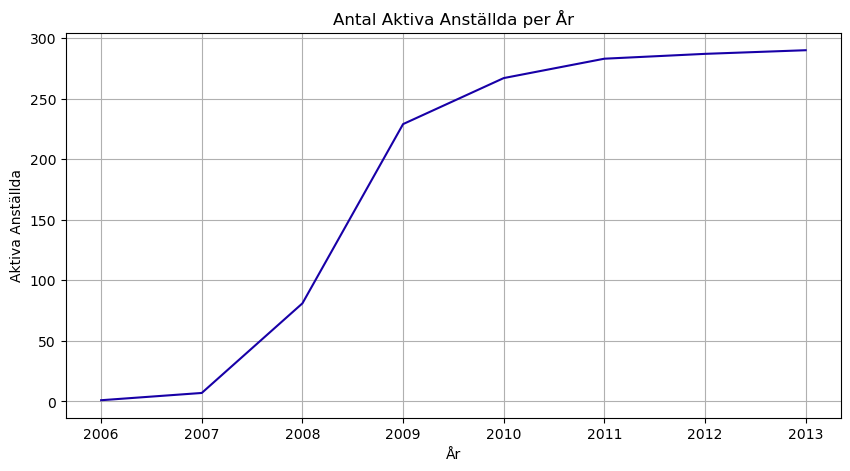

In [29]:

plt.figure(figsize=(10, 5))
sns.lineplot(data=ÅrAktivaAnställda, x="År", y="Aktiva Anställda")

plt.title("Antal Aktiva Anställda per År")

plt.xlabel("År")

plt.ylabel("Aktiva Anställda")

plt.grid(True)

plt.show()





In [30]:
# Kolla på POMS, har det varit mycket POMS under åren?
POMS = """
    SELECT 
        EDH.BusinessEntityID AS [Anställnings Nummer]
        , COUNT(DISTINCT EDH.BusinessEntityID) AS POMS

    FROM HumanResources.EmployeeDepartmentHistory AS EDH
        INNER JOIN HumanResources.Employee AS E
            ON EDH.BusinessEntityID = E.BusinessEntityID

    WHERE EndDate IS NOT NULL 
        AND Currentflag = 0

    GROUP BY EDH.BusinessEntityID  
    ;
"""
POMS = pd.read_sql(POMS, engine)
POMS

,Anställnings Nummer,POMS


In [31]:
# Hur ser det ut med avdelningändringar? Finns det många befordran?

AvdelningByta = """
    WITH AvdelningÄndring AS (
        SELECT 
            EDH.BusinessEntityID  
            , EDH.DepartmentID
            , EDH.StartDate
            , EDH.EndDate
            , COUNT(*) OVER (PARTITION BY EDH.BusinessEntityID) AS [Avdelningar ändringar]
            , D.Name AS [Avdelning]
        FROM 
            HumanResources.EmployeeDepartmentHistory AS EDH
                INNER JOIN HumanResources.Department AS D 
                    ON EDH.DepartmentID = D.DepartmentID
    )
    
    SELECT
        BusinessEntityID AS [Anställnings Nummer]
        , DepartmentID AS [Dept ID]
        , [Avdelning]
        , StartDate AS [Start Date]
        , EndDate AS [End Date]
   
    FROM AvdelningÄndring
    WHERE [Avdelningar ändringar] > 1
    ;
"""
AvdelningByta = pd.read_sql(AvdelningByta, engine)
AvdelningByta

,Anställnings Nummer,Dept ID,Avdelning,Start Date,End Date
0,4,1,Engineering,2007-12-05,2010-05-30
1,4,2,Tool Design,2010-05-31,None
2,16,5,Purchasing,2007-12-20,2009-07-14
3,16,4,Marketing,2009-07-15,None
4,224,7,Production,2009-01-07,2011-08-31
5,224,8,Production Control,2011-09-01,None
6,234,10,Finance,2009-01-31,2013-11-13
7,234,16,Executive,2013-11-14,None
8,250,4,Marketing,2011-02-25,2011-07-30
9,250,13,Quality Assurance,2011-07-31,2012-07-14


In [32]:
# Årliglön per anställd (baserat på senaste lön) sorterat per avdelning
LönPerÅr = """
    SELECT
        E.BusinessEntityID AS [Anställningsnummer]
        , E.Gender AS Kön
        , YEAR(EPH.ModifiedDate) - YEAR(E.BirthDate) -
            CASE 
                 WHEN MONTH(EPH.ModifiedDate) > MONTH(E.BirthDate) OR 
                      (MONTH(EPH.ModifiedDate) = MONTH(E.BirthDate) AND DAY(EPH.ModifiedDate) >= DAY(E.BirthDate)) 
                 THEN 0 
                 ELSE 1 
            END AS Ålder
    
        , 40 * 52 * EPH.Rate AS [Årlig Lön]  -- Antar 40 timmar/vecka och 52 veckor/år
        , D.DepartmentID AS [Avdelning ID]
        , D.[Name] AS [Avdelning]
    FROM  
        HumanResources.EmployeeDepartmentHistory AS EDH
            INNER JOIN (
                        SELECT 
                            BusinessEntityID 
                            , Rate
                            , ModifiedDate
                            , ROW_NUMBER() OVER (PARTITION BY BusinessEntityID ORDER BY ModifiedDate DESC) AS [row]
                         FROM HumanResources.EmployeePayHistory
                        ) AS EPH
                ON EDH.BusinessEntityID = EPH.BusinessEntityID AND EPH.[row] = 1  -- Säkerställa att endast att bara en rad för varje anställd

            INNER JOIN HumanResources.Department AS D
                ON EDH.DepartmentID = D.DepartmentID

            INNER JOIN HumanResources.Employee AS E
                ON EDH.BusinessEntityID = E.BusinessEntityID

    WHERE E.CurrentFlag = 1
    ORDER BY 
        EDH.DepartmentID
        , [Årlig Lön] ASC
        , E.Gender
    ;
"""

LönPerÅr = pd.read_sql(LönPerÅr, engine)
LönPerÅr.head(50)

,Anställningsnummer,Kön,Ålder,Årlig Lön,Avdelning ID,Avdelning
0,4,M,36,62080.096,1,Engineering
1,5,F,61,67999.984,1,Engineering
2,15,F,53,67999.984,1,Engineering
3,6,M,55,67999.984,1,Engineering
4,14,M,35,75000.016,1,Engineering
5,3,M,39,89999.936,1,Engineering
6,2,F,42,131999.920,1,Engineering
7,13,F,25,52000.000,2,Tool Design
8,12,M,54,52000.000,2,Tool Design
9,11,M,36,60000.096,2,Tool Design


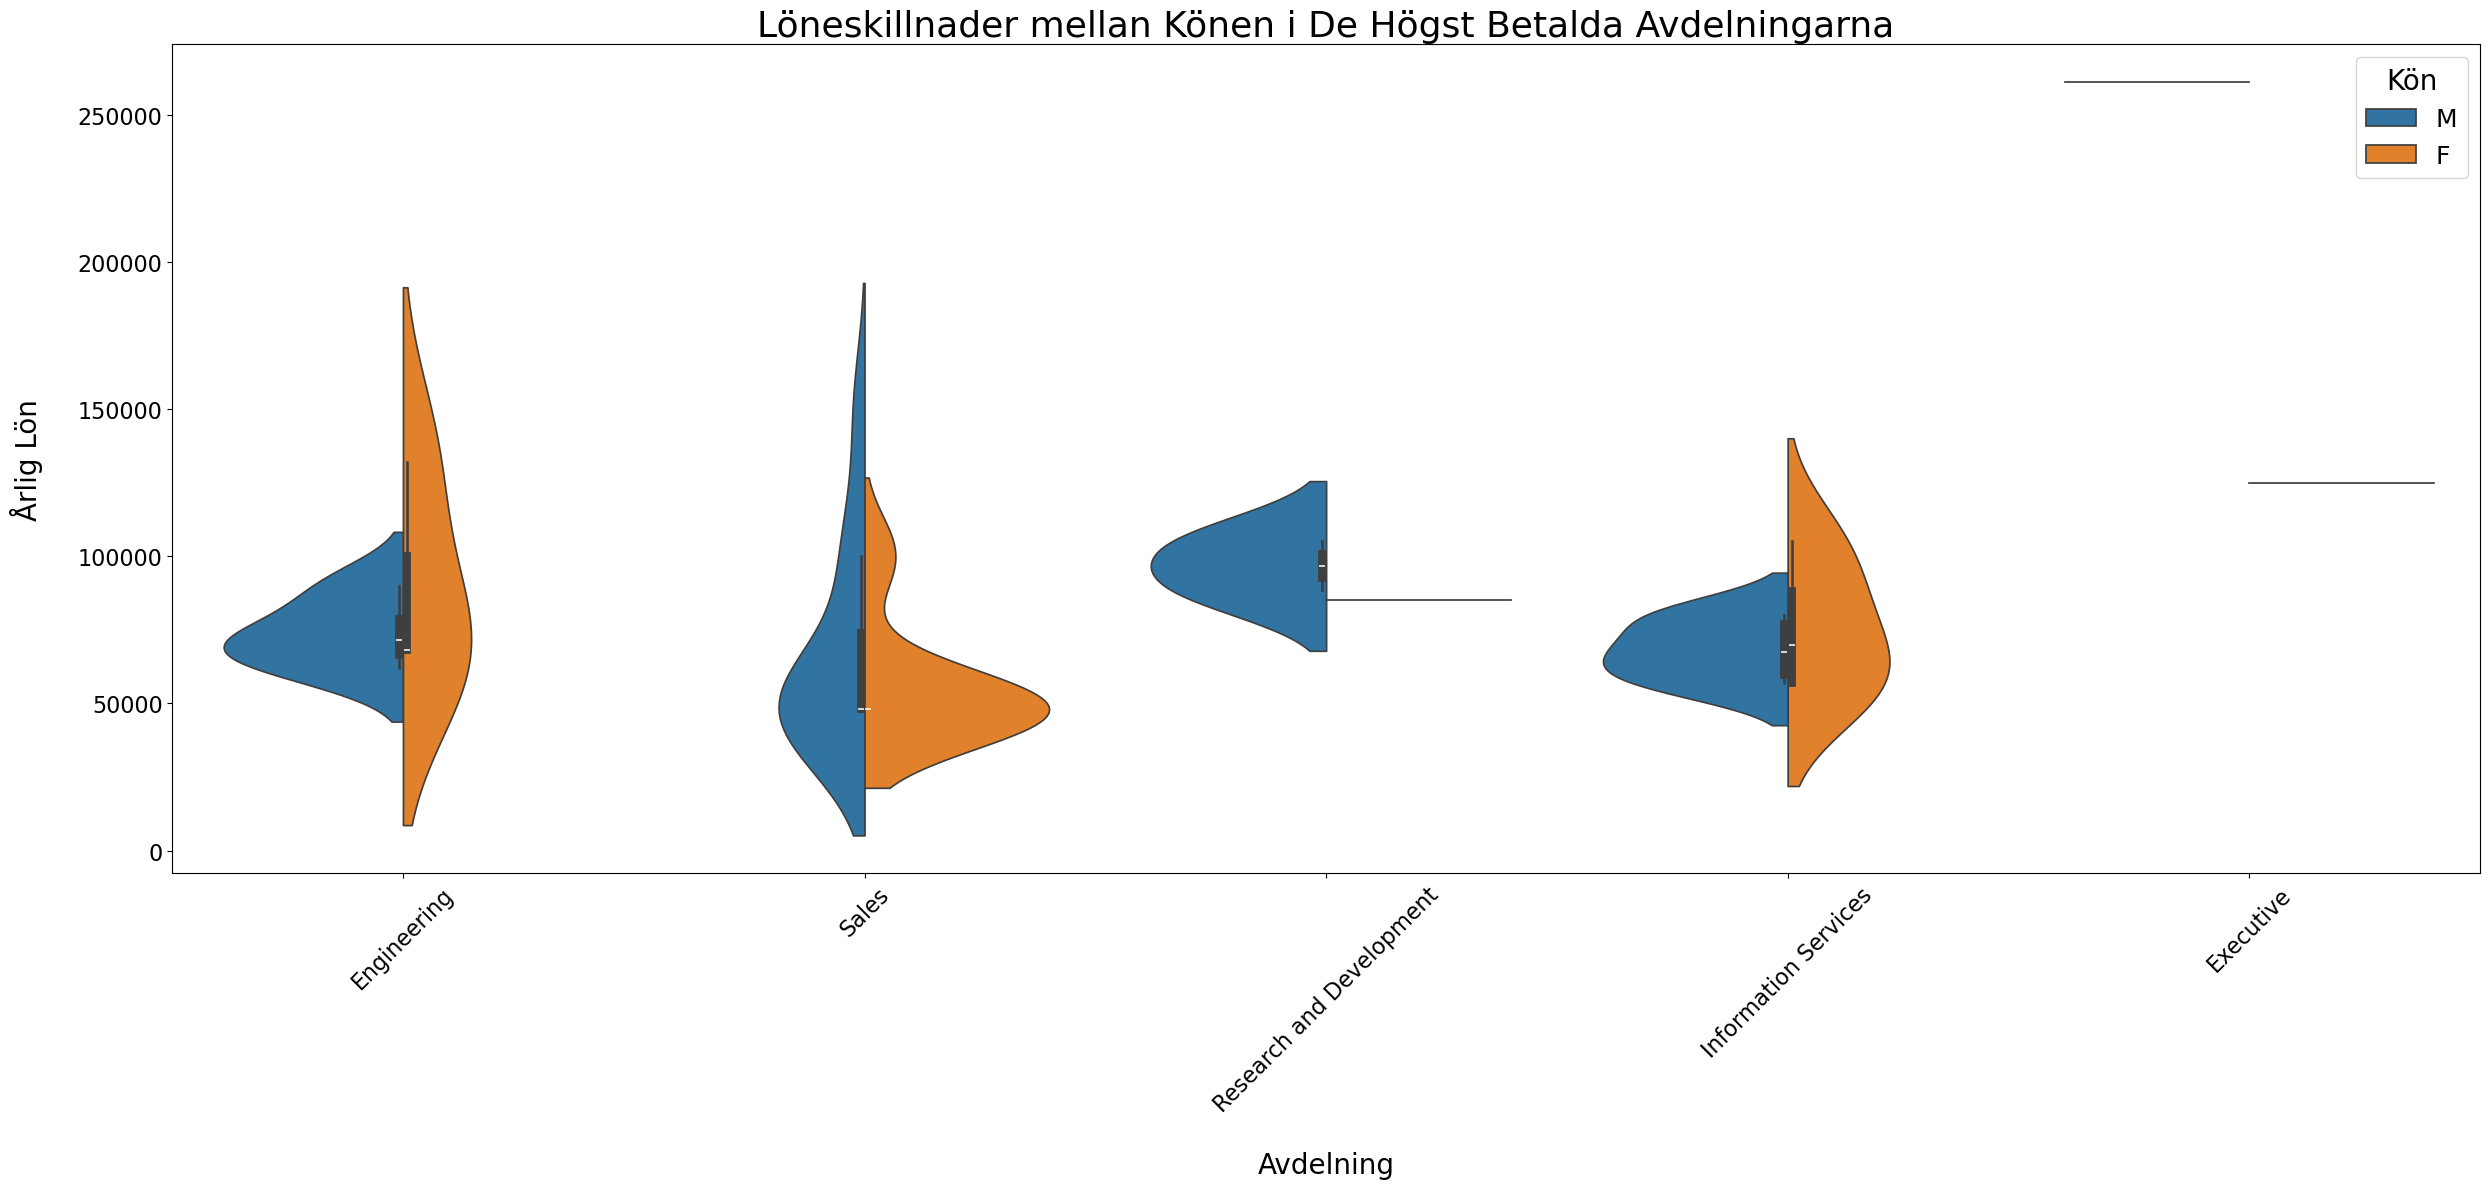

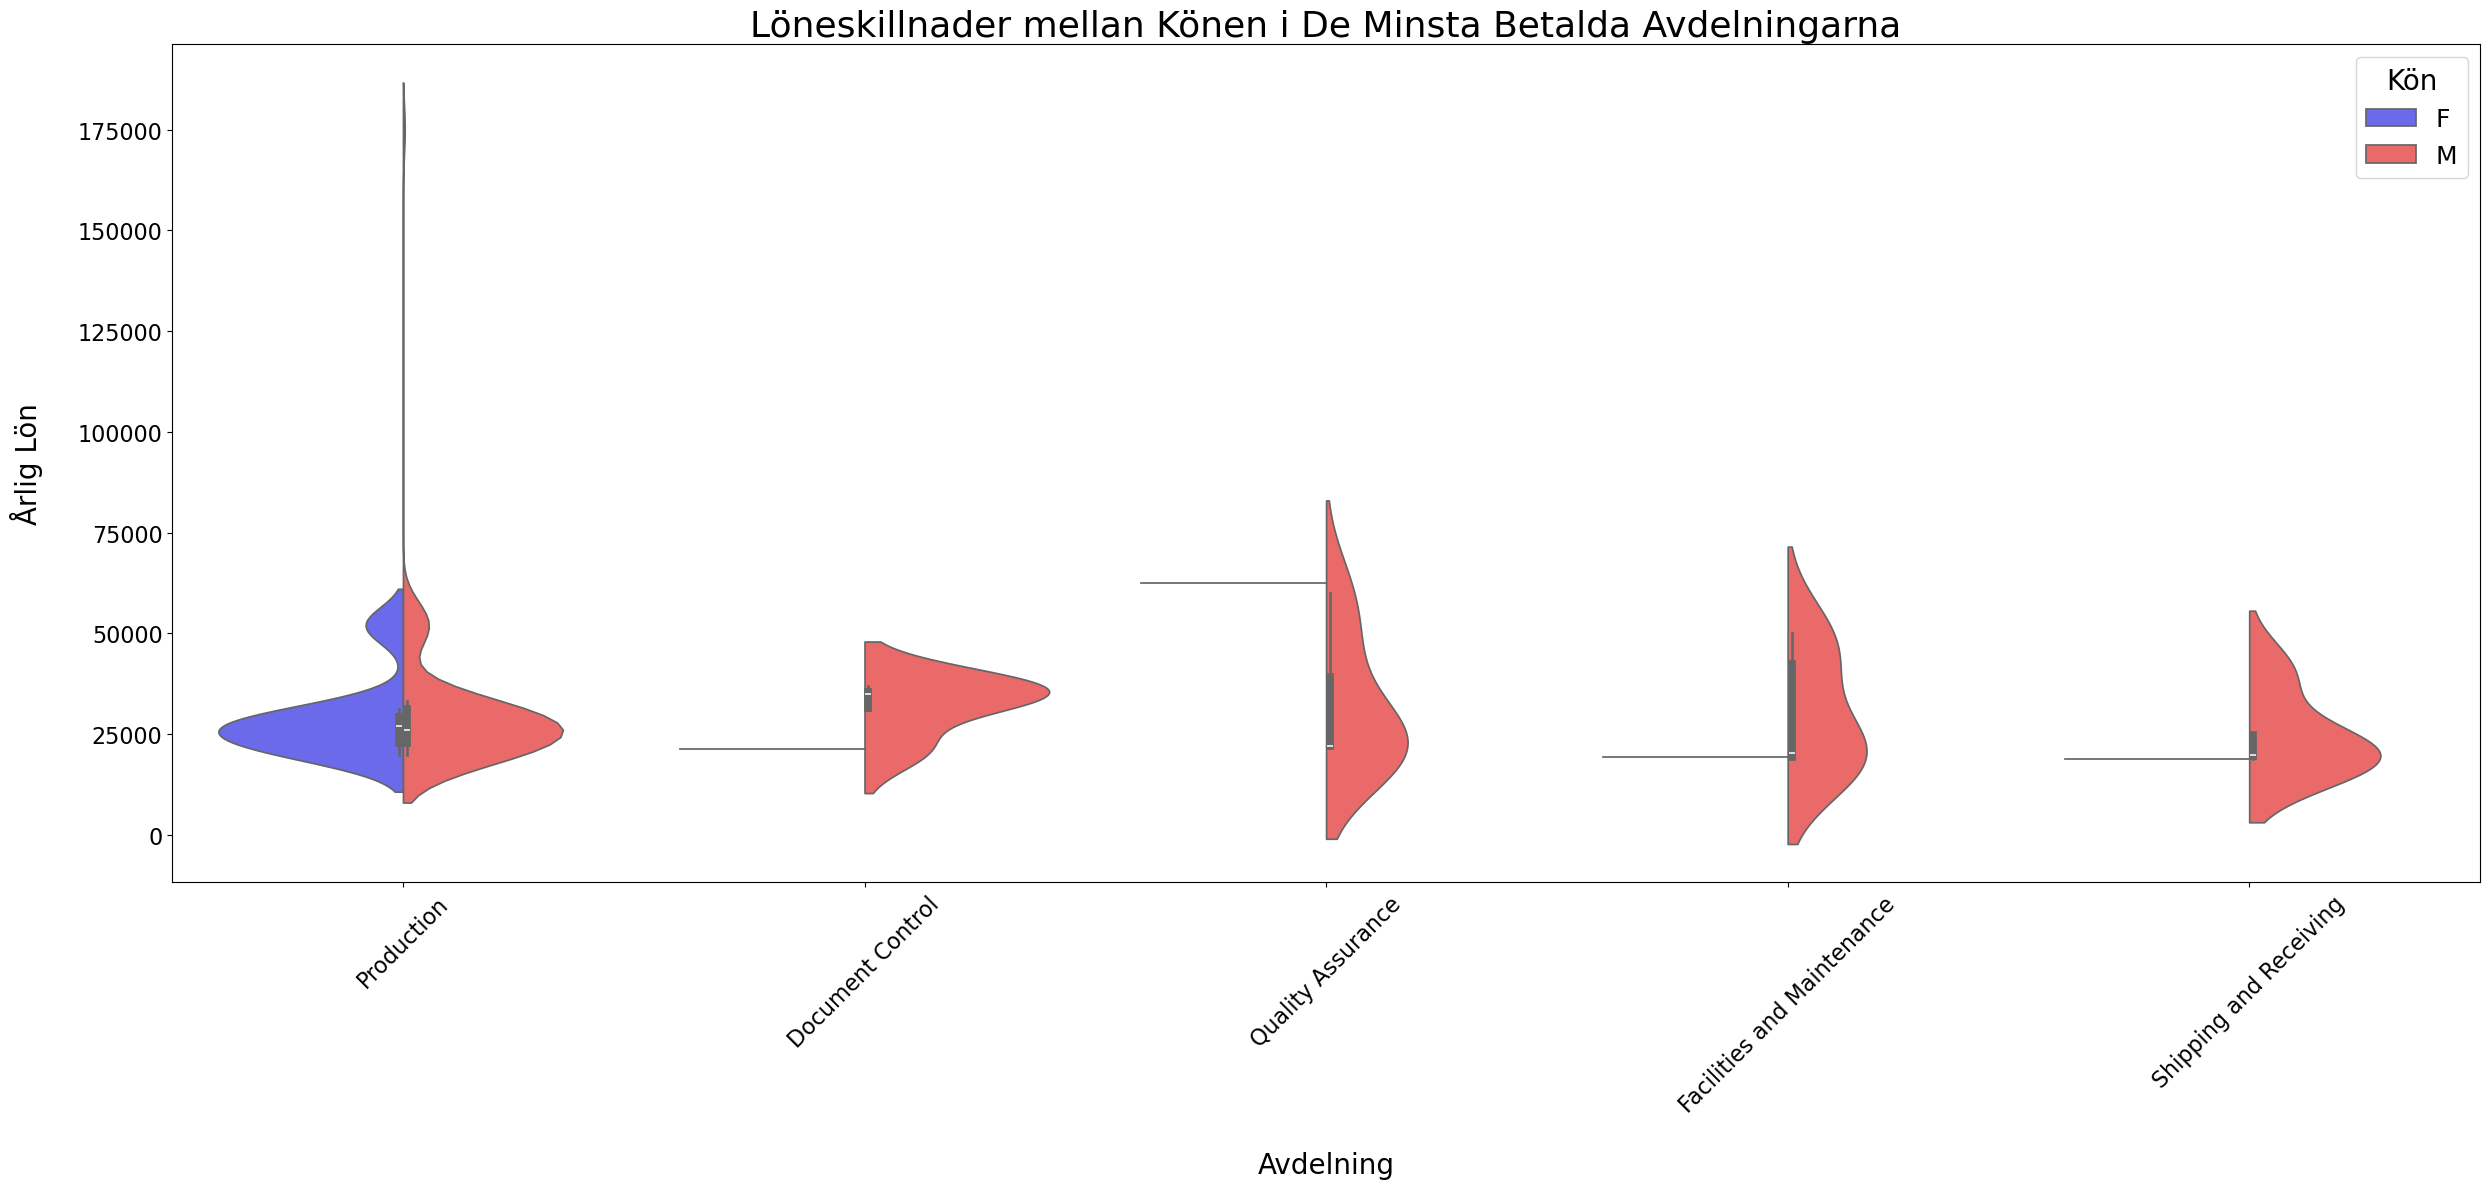

In [33]:
# Beräkna snitt lön per avdelning och sortera topp avdelningar
snitt_lön_avdelning = LönPerÅr.groupby('Avdelning')['Årlig Lön'].mean()
topp_avdelningar = snitt_lön_avdelning.nlargest(5).index
botten_avdelningar = snitt_lön_avdelning.nsmallest(5).index

# Filtrera tabelen för topp 5 avdelningar för att sen visulisera
LönPerÅr_Modifierad = LönPerÅr[LönPerÅr['Avdelning'].isin(topp_avdelningar)]

plt.figure(figsize = (25, 12))
sns.violinplot(data = LönPerÅr_Modifierad, x='Avdelning', y='Årlig Lön', hue='Kön',
               split=True, palette='tab10')
plt.title('Löneskillnader mellan Könen i De Högst Betalda Avdelningarna', fontsize=26)

plt.xticks(rotation=45, fontsize=16)
plt.xlabel('Avdelning', labelpad=25, fontsize = 20)

plt.yticks(fontsize=16)
plt.ylabel('Årlig Lön', labelpad=25, fontsize=20)

legend = plt.legend(title='Kön', fontsize = 18)
legend.get_title().set_fontsize(20)

plt.tight_layout()
plt.show()

# Filtrera tabelen för botten 5 avdelningar för att sen visulisera
LönPerÅr_Modifierad = LönPerÅr[LönPerÅr['Avdelning'].isin(botten_avdelningar)]

plt.figure(figsize = (25, 12))
sns.violinplot(data = LönPerÅr_Modifierad, x='Avdelning', y='Årlig Lön', hue='Kön',
               split=True, palette='seismic')
plt.title('Löneskillnader mellan Könen i De Minsta Betalda Avdelningarna', fontsize=26)

plt.xticks(rotation=45, fontsize=16)
plt.xlabel('Avdelning', labelpad=25, fontsize = 20)

plt.yticks(fontsize=16)
plt.ylabel('Årlig Lön', labelpad=25, fontsize=20)

legend = plt.legend(title='Kön', fontsize = 18)
legend.get_title().set_fontsize(20)

plt.tight_layout()
plt.show()



In [34]:
# Finns det något statistisk skillnad mellan män och kvinnor lön?
# Beräknar först statisik 
löner_statistik = LönPerÅr.groupby('Kön')['Årlig Lön'].agg(['mean', 'std', 'count'])

M_mean = löner_statistik.loc['M', 'mean']
M_std = löner_statistik.loc['M', 'std']
M_count = löner_statistik.loc['M', 'count']

K_mean = löner_statistik.loc['F', 'mean']
K_std = löner_statistik.loc['F', 'std']
K_count = löner_statistik.loc['F', 'count']

# Beräkna standardfelet
M_stdfel = M_std / np.sqrt(M_count)
K_stdfel = K_std / np.sqrt(K_count)

# Utför ett t-test och kolla p-värde, jämför män och kvinnor
t_värde, p_värde = stats.ttest_ind( LönPerÅr[LönPerÅr['Kön'] == 'M']['Årlig Lön'], 
                                    LönPerÅr[LönPerÅr['Kön'] == 'F']['Årlig Lön'],
                                    equal_var=False)
                                   

# Beräkna konfidensintervall för varje kön kolla om dem överlappa
K_Intervall_Män = stats.norm.interval(0.95, loc=M_mean, scale=M_stdfel)
K_Intervall_Kvinnor = stats.norm.interval(0.95, loc=K_mean, scale=K_stdfel)

print(f"T-värde: {t_värde:.2f},\nP-värde: {p_värde:.2f}")
print(f"Konfidensintervall för män: {K_Intervall_Män[0]:.2f} - {K_Intervall_Män[1]:.2f}")
print(f"Konfidensintervall för kvinnor: {K_Intervall_Kvinnor[0]:.2f} - {K_Intervall_Kvinnor[1]:.2f}")


T-värde: -1.29,
P-värde: 0.20
Konfidensintervall för män: 33703.73 - 40792.29
Konfidensintervall för kvinnor: 36101.94 - 46874.69


In [44]:
# Hur ser kön fördelning ut per avdelning

AvdelnnigKönFördelning = """
    SELECT 
        D.[Name] AS [Avdelning]
        , COUNT(CASE 
                    WHEN E.Gender = 'M' THEN 1 
                END) AS [Antal Män]
        , COUNT(CASE
                    WHEN E.Gender = 'F' THEN 1 
                END) AS [Antal Kvinnor]

        FROM HumanResources.Employee AS E
            INNER JOIN HumanResources.EmployeeDepartmentHistory AS EDH 
                ON E.BusinessEntityID = EDH.BusinessEntityID

            INNER JOIN HumanResources.Department AS D 
                ON EDH.DepartmentID = D.DepartmentID

        WHERE E.CurrentFlag = 1
        GROUP BY 
            EDH.DepartmentID
            , D.[Name]
        ORDER BY EDH.DepartmentID
    ;
"""
AvdelnnigKönFördelning = pd.read_sql(AvdelnnigKönFördelning, engine)
AvdelnnigKönFördelning

,Avdelning,Antal Män,Antal Kvinnor
0,Engineering,4,3
1,Tool Design,3,1
2,Sales,11,7
3,Marketing,5,5
4,Purchasing,9,4
5,Research and Development,2,2
6,Production,134,46
7,Production Control,6,0
8,Human Resources,4,2
9,Finance,5,6


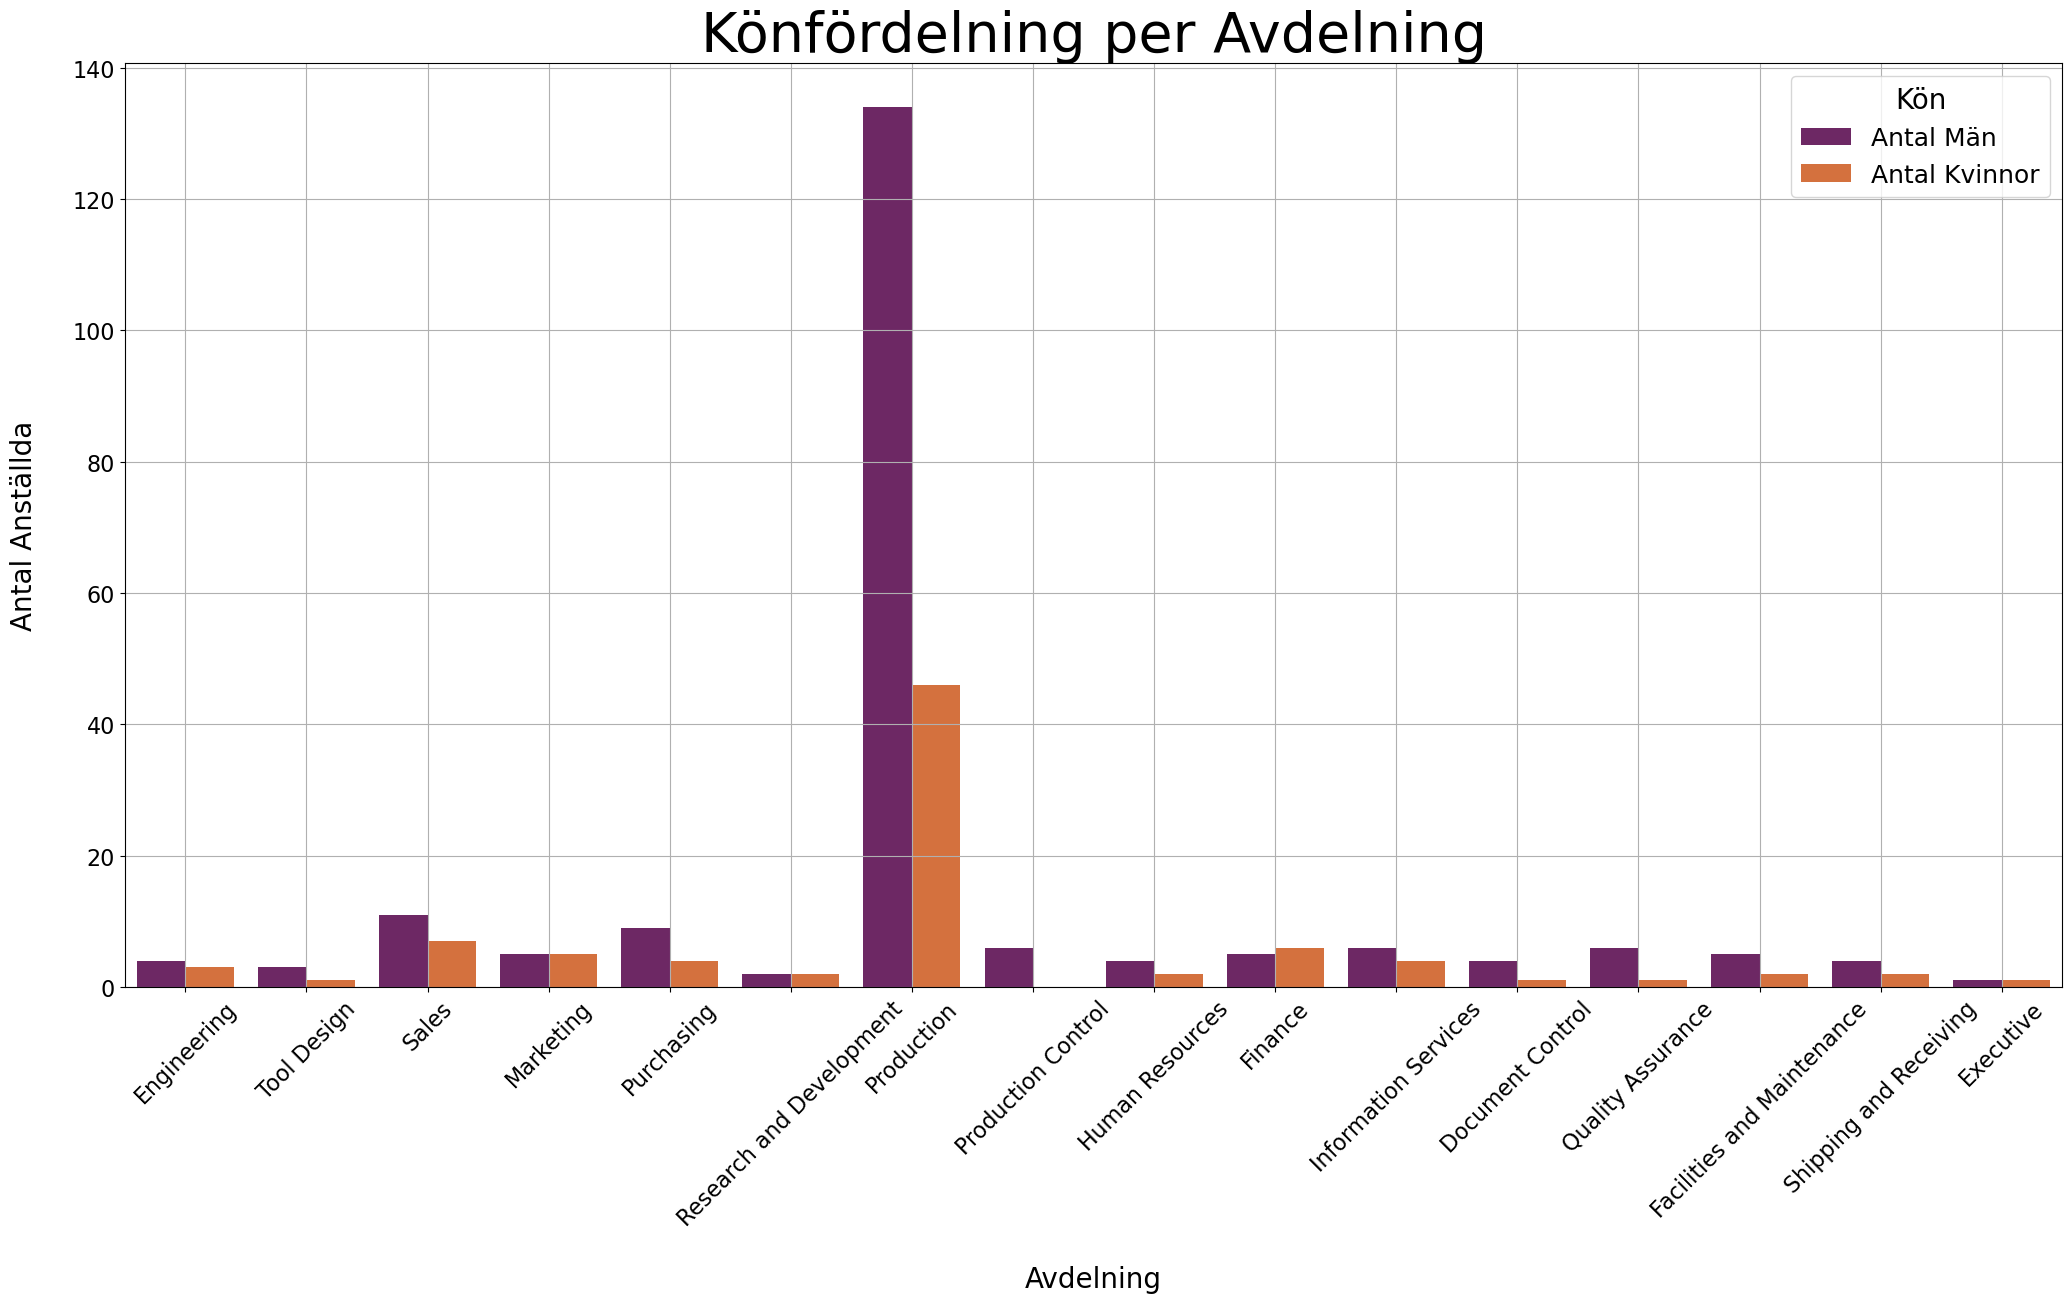

In [36]:
# Ändra AvdelningKönFördelning för att kunna göra en barplot
AvdelnnigKönFördelning = AvdelnnigKönFördelning.melt(id_vars=['Avdelning'], value_vars=['Antal Män', 'Antal Kvinnor'],
                                        var_name='Kön', value_name='Antal')

plt.figure(figsize = (25, 12))
sns.barplot(data=AvdelnnigKönFördelning, x='Avdelning', y='Antal', hue='Kön', palette='inferno')

plt.title('Könfördelning per Avdelning', fontsize=40)

plt.xticks(rotation=45, fontsize=16)
plt.xlabel('Avdelning', labelpad=25, fontsize=20)

plt.yticks(fontsize=16)
plt.ylabel('Antal Anställda', labelpad=25, fontsize=20)

plt.legend(title='Kön', fontsize=18, title_fontsize=20)

plt.grid(True)

plt.show()

In [45]:
# Statistisk skillnad med andel män och kvinnor i företag som helhet?

antal_män = AvdelnnigKönFördelning['Antal Män'].sum()
antal_kvinnor = AvdelnnigKönFördelning['Antal Kvinnor'].sum()

total_antal = antal_män + antal_kvinnor


prop_män = antal_män / total_antal
prop_kvinnor = antal_kvinnor / total_antal


SE = np.sqrt(prop_män * (1 - prop_män) / total_antal + prop_kvinnor * (1 - prop_kvinnor) / total_antal)


z_stat = (prop_män - prop_kvinnor) / SE


p_värde = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print('Z-statistik:', z_stat)
print('P-värde:', p_värde)






Z-statistik: 11.006720010404997
P-värde: 0.0


## Produkter och Lagar

In [46]:
# Produkter i lager. Använder CTE då produkter finns på flera platser

Produkter_i_Lagar = """
    WITH ProduktTotalAntal 
    AS (
    SELECT 
            P.ProductID AS [Produkt ID]
            , SUM([PI].Quantity) AS [Antal i Lagar]
        FROM 
            Production.Product AS P
                INNER JOIN Production.ProductInventory AS [PI]
                    ON P.ProductID = [PI].ProductID
        GROUP BY 
            P.ProductID
    )

    SELECT 
        P.ProductID
        , P.Name AS ProductName
        , PTA.[Antal i Lagar]
    FROM 
        Production.Product AS P
            INNER JOIN ProduktTotalAntal AS PTA
                ON P.ProductID = PTA.[Produkt ID]
    ORDER BY 
        PTA.[Antal i Lagar] ASC
    ;
"""
Produkter_i_Lagar = pd.read_sql(Produkter_i_Lagar, engine)
Produkter_i_Lagar.head(20)


,ProductID,ProductName,Antal i Lagar
0,859,"Half-Finger Gloves, M",0
1,876,Hitch Rack - 4-Bike,0
2,882,"Short-Sleeve Classic Jersey, M",0
3,853,"Women's Tights, M",0
4,854,"Women's Tights, L",36
5,883,"Short-Sleeve Classic Jersey, L",36
6,860,"Half-Finger Gloves, L",36
7,877,Bike Wash - Dissolver,36
8,492,Paint - Black,47
9,494,Paint - Silver,65


In [47]:
# Beräkna medelvärde och standardavvikelse för lagret
medel = Produkter_i_Lagar['Antal i Lagar'].mean()
std = Produkter_i_Lagar['Antal i Lagar'].std()
n = len(Produkter_i_Lagar['Antal i Lagar'])

stdfel = std / np.sqrt(n)

interval = stats.t.interval(0.95, df=n-1, loc=medel, scale=stdfel)

print(f"95% konfidensintervall för snitt lagermängder är: {interval[0]:.2f} - {interval[1]:.2f}")


95% konfidensintervall för snitt lagermängder är: 723.40 - 832.03


In [48]:
# Defektorsak och defektantal

DefektOrsak = """
    SELECT
        SR.[Name] AS [Defekt Orsak]
        , COUNT(*) AS [Antal Defekt]
    FROM
        Production.ScrapReason AS SR
            INNER JOIN Production.WorkOrder AS WO
                ON SR.ScrapReasonID = WO.ScrapReasonID
    GROUP BY
        SR.[Name]
    ORDER BY
        [Antal Defekt] 
        , SR.[Name]
    ;
"""
DefektOrsak = pd.read_sql(DefektOrsak, engine)
DefektOrsak

,Defekt Orsak,Antal Defekt
0,Handling damage,32
1,Paint process failed,37
2,Seat assembly not as ordered,37
3,Thermoform temperature too high,37
4,Drill size too large,42
5,Brake assembly not as ordered,44
6,Color incorrect,44
7,Drill size too small,44
8,Drill pattern incorrect,45
9,Primer process failed,47


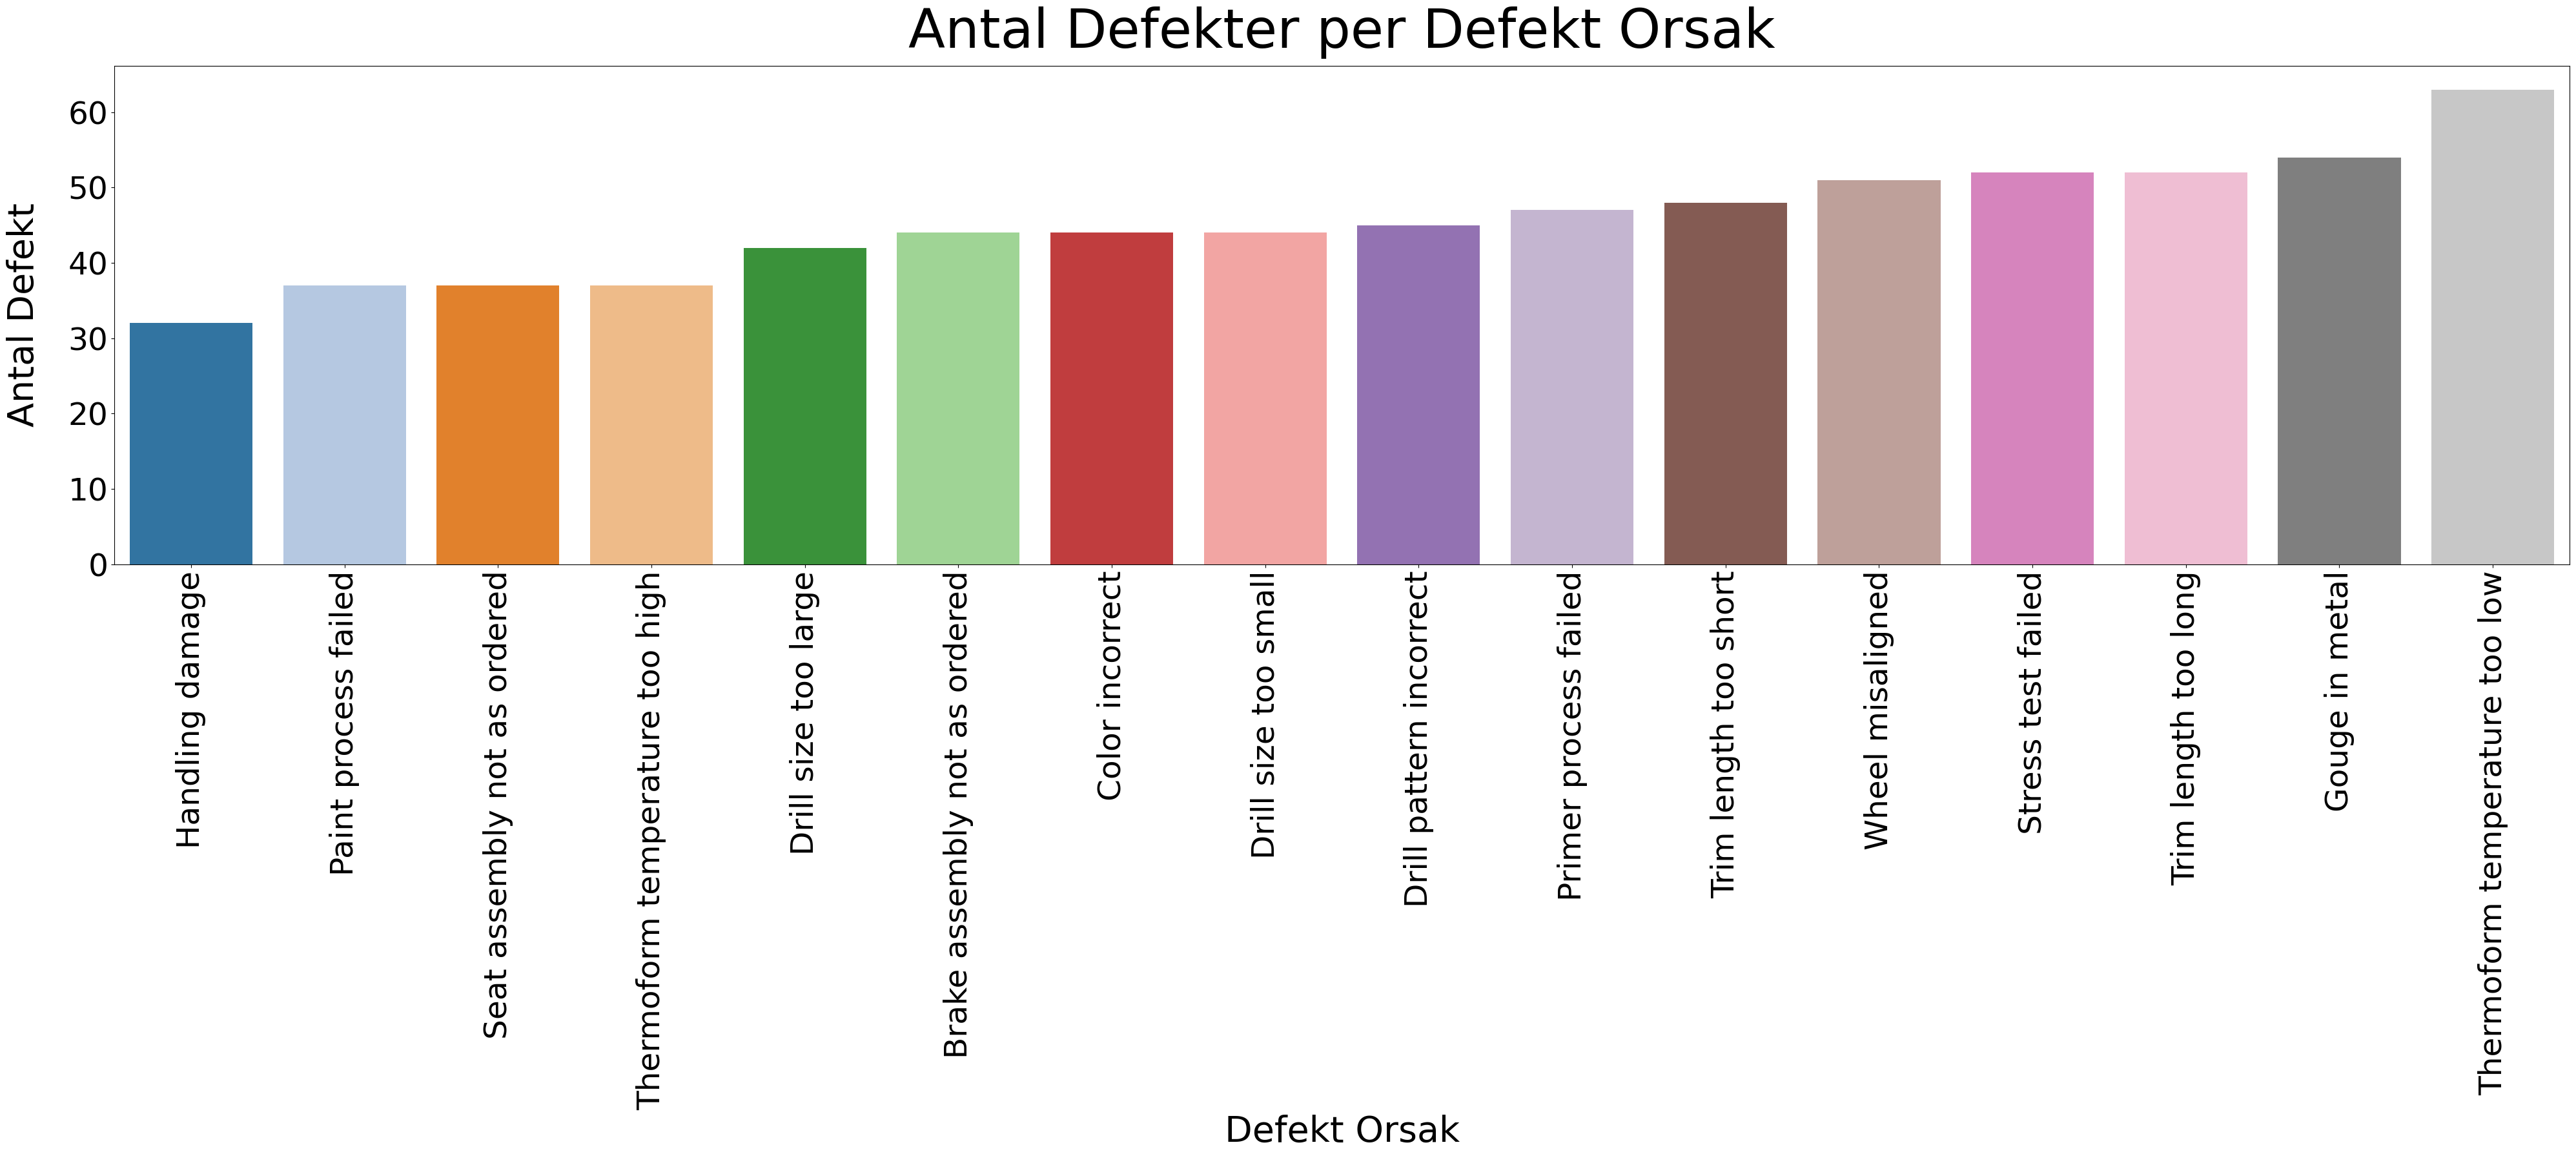

In [49]:
# stapeldiagram för defektorsak vs defektantal

plt.figure(figsize = (40, 18))
sns.barplot(data=DefektOrsak, x='Defekt Orsak', y='Antal Defekt', hue='Defekt Orsak', palette='tab20')

plt.title('Antal Defekter per Defekt Orsak', fontsize=60, pad=20)


plt.xlabel('Defekt Orsak', fontsize=40, labelpad=5)
plt.xticks(rotation=90, fontsize=35)

plt.ylabel('Antal Defekt', fontsize=40, labelpad=30)
plt.yticks(fontsize=35)

plt.tight_layout()

plt.show()

In [50]:
# Produktnamn och portion defekt
DefektPortion = """
    WITH DefektAntal
    AS (
        SELECT
            WO.ProductID
            , COUNT(*) AS [Antal Defekt]
        FROM
            Production.WorkOrder AS WO
                INNER JOIN Production.ScrapReason AS SR 
                    ON WO.ScrapReasonID = SR.ScrapReasonID
        GROUP BY
            WO.ProductID
    ),

    ProduktAntal 
    AS (
        SELECT
            ProductID
            , COUNT(*) AS [Totalt Antal Produkter]
        FROM
            Production.WorkOrder
        GROUP BY
            ProductID
    )

    SELECT
        P.ProductID
        , P.[Name] AS [Produktnamn]
        , DA.[Antal Defekt]
        , PA.[Totalt Antal Produkter]
        , ROUND(CAST(DA.[Antal Defekt] AS FLOAT) / PA.[Totalt Antal Produkter], 2) AS [Defekt Portion]
    FROM
        Production.Product AS P
            LEFT JOIN DefektAntal DA 
                ON P.ProductID = DA.ProductID
            LEFT JOIN ProduktAntal PA 
                ON P.ProductID = PA.ProductID
    WHERE 
        DA.[Antal Defekt] IS NOT NULL
    ORDER BY
        [Defekt Portion] DESC
        , P.ProductID
    ;

"""
DefektPortion = pd.read_sql(DefektPortion, engine)
DefektPortion

,ProductID,Produktnamn,Antal Defekt,Totalt Antal Produkter,Defekt Portion
0,733,"ML Road Frame - Red, 52",4,21,0.19
1,756,"Road-450 Red, 44",2,12,0.17
2,3,BB Ball Bearing,98,1093,0.09
3,515,ML Mountain Seat Assembly,1,12,0.08
4,734,"ML Road Frame - Red, 58",1,12,0.08
...,...,...,...,...,...
162,949,LL Crankset,1,376,0.00
163,951,HL Crankset,3,716,0.00
164,977,"Road-750 Black, 58",1,225,0.00
165,995,ML Bottom Bracket,1,710,0.00


In [51]:
# Finns det stora variationer i defektandel?
standardavvikelse_defekt = DefektPortion['Defekt Portion'].std()
print(f"Standardavvikelsen för defektandelar är: {standardavvikelse_defekt}")

Standardavvikelsen för defektandelar är: 0.026935434643234453


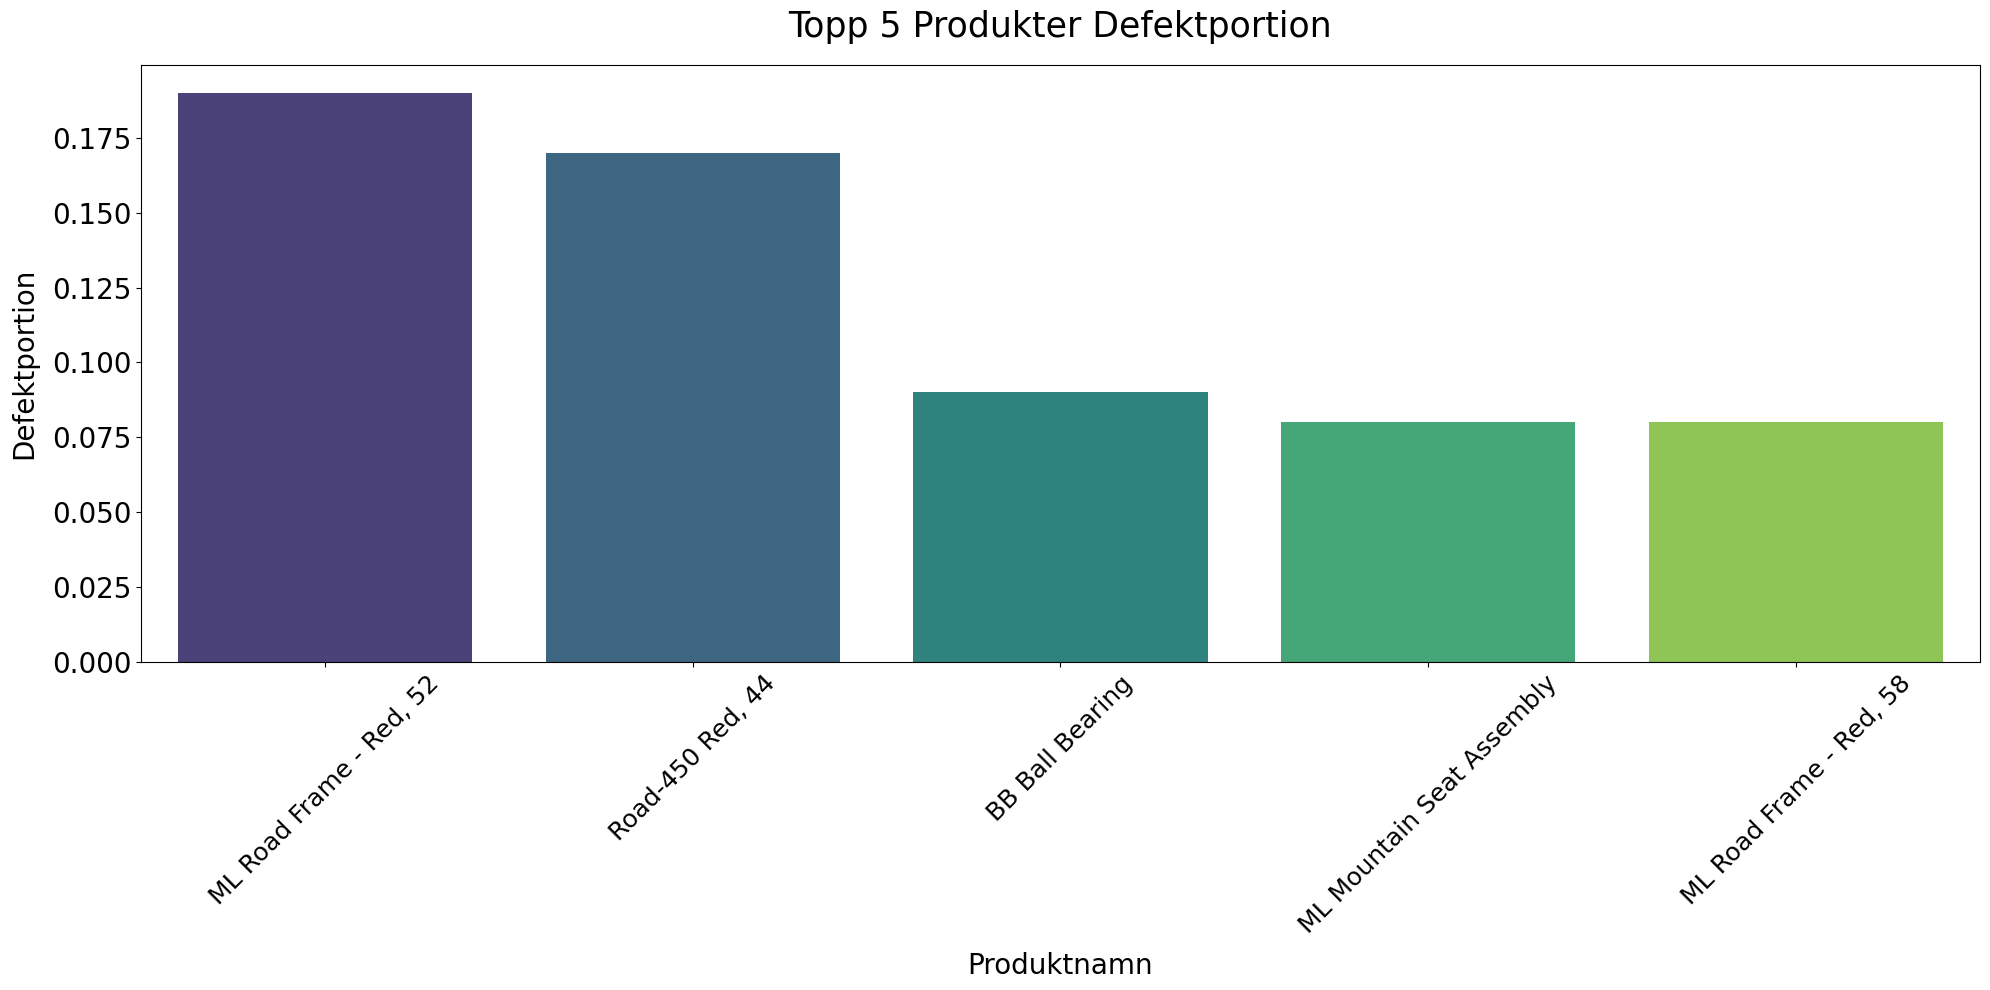

In [52]:
# Diagram defekt portion på topp 5 produkter
topp_DefektPortion = DefektPortion.nlargest(5, 'Defekt Portion')

plt.figure(figsize = (20, 10))
sns.barplot(data=topp_DefektPortion, x='Produktnamn', y='Defekt Portion'
            ,hue='Produktnamn', palette='viridis')

plt.title('Topp 5 Produkter Defektportion', fontsize=25, pad=20)

plt.xlabel('Produktnamn', fontsize=20, labelpad=10)
plt.xticks(rotation=45, fontsize=18)

plt.ylabel('Defektportion', fontsize=20, labelpad=10)
plt.yticks(fontsize=20)

plt.tight_layout()

plt.show()


In [53]:
# Hitta snitt produktionstid per produkt, Hur ser produktions tid ut vs planerade produktionstid?
ProduktionTid = """
    WITH ProduktionSnittTid 
    AS (
        SELECT 
            WO.ProductID
            , P.[Name] AS [Produktnamn]
            , AVG(DATEDIFF(HOUR, WOR.ActualStartDate, WOR.ActualEndDate)) 
                OVER (PARTITION BY WO.ProductID) AS [Snitt Produktions Tid]
            , DATEDIFF(hour, WOR.ScheduledStartDate, WOR.ScheduledEndDate) AS [Planerad Produktions Tid]
        FROM 
            Production.WorkOrderRouting AS WOR
                INNER JOIN Production.WorkOrder AS WO
                    ON WOR.WorkOrderID = WO.WorkOrderID
    
                INNER JOIN Production.Product AS P
                    ON WO.ProductID = P.ProductID
        WHERE 
            WOR.ActualStartDate IS NOT NULL AND 
            WOR.ActualEndDate IS NOT NULL
    )

    SELECT DISTINCT
        PST.ProductID
        , PST.Produktnamn
        , PST.[Snitt Produktions Tid]
        , PST.[Planerad Produktions Tid]
        , PST.[Snitt Produktions Tid] - PST.[Planerad Produktions Tid] AS [Produktion Avvikelse]
    FROM 
        ProduktionSnittTid AS PST
    ORDER BY
        PST.[Snitt Produktions Tid] DESC
        , PST.Produktnamn
    ;
   
"""
ProduktionTid = pd.read_sql(ProduktionTid, engine)
ProduktionTid

,ProductID,Produktnamn,Snitt Produktions Tid,Planerad Produktions Tid,Produktion Avvikelse
0,814,"ML Mountain Frame - Black, 38",384,264,120
1,809,ML Mountain Handlebars,384,264,120
2,515,ML Mountain Seat Assembly,384,264,120
3,785,"Mountain-300 Black, 38",384,264,120
4,786,"Mountain-300 Black, 40",384,264,120
...,...,...,...,...,...
144,968,"Touring-1000 Blue, 54",279,264,15
145,750,"Road-150 Red, 44",278,264,14
146,753,"Road-150 Red, 56",277,264,13
147,962,"Touring-3000 Yellow, 50",277,264,13


In [54]:
# Hur signifikant är dessa avikelser?
medel_avvikelse = ProduktionTid['Produktion Avvikelse'].mean()
stdavvikelse_avvikelse = ProduktionTid['Produktion Avvikelse'].std()

print(f"Medelvärdet för produktionsavvikelser är: {medel_avvikelse}")
print(f"Standardavvikelsen för produktionsavvikelser är: {stdavvikelse_avvikelse}")

Medelvärdet för produktionsavvikelser är: 44.51006711409396
Standardavvikelsen för produktionsavvikelser är: 27.31216377111726


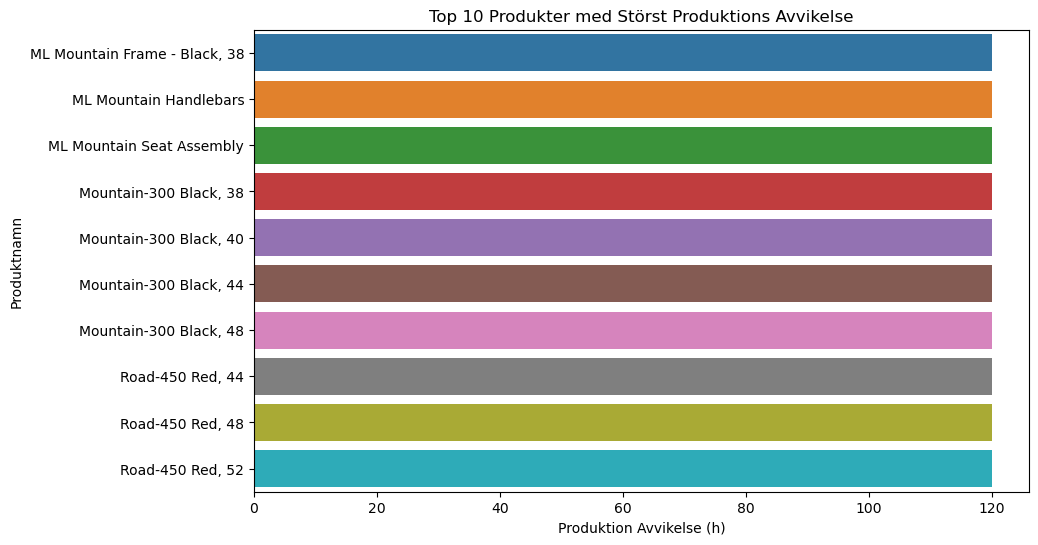

In [55]:
# Visulisera topp 5 produkter som inte klara produktions plannerade tid
topp_ProduktionAvvikelser = ProduktionTid.nlargest(10, 'Produktion Avvikelse')

plt.figure(figsize=(10, 6))
sns.barplot(data=topp_ProduktionAvvikelser, x='Produktion Avvikelse', y='Produktnamn', 
            hue='Produktnamn' , palette='tab10')


plt.xlabel('Produktion Avvikelse (h)')

plt.ylabel('Produktnamn')

plt.title('Top 10 Produkter med Störst Produktions Avvikelse')

plt.show()



In [56]:
#Eftersom top 10 produkter ta 2 extra timmar vilken procent av produkter inte klara sin planerade tid?

# Beräknar antal produkter som tar längre tid än planerad
ProcentFörsenad = ((ProduktionTid['Snitt Produktions Tid'] > \
                    ProduktionTid['Planerad Produktions Tid']).sum() / len(ProduktionTid)) * 100

print(f"Percentage of products not meeting their planned production time: {ProcentFörsenad:.2f}%")


Percentage of products not meeting their planned production time: 100.00%


## Sales

In [57]:
# Produkter och snitt pris
ProdukterSnittPris = """
    SELECT
        P.ProductID 
        , P.[Name] AS Produkt
        , SUM(SOD.OrderQty) AS [Total Sålt]
        , AVG(SOD.UnitPrice) AS [Snitt Pris]
    FROM 
        Sales.SalesOrderDetail AS SOD
            INNER JOIN Production.Product AS P
                ON SOD.ProductID = P.ProductID
    GROUP BY 
        P.ProductID
        , P.Name
    ;
"""
ProdukterSnittPris = pd.read_sql(ProdukterSnittPris, engine)
ProdukterSnittPris

,ProductID,Produkt,Total Sålt,Snitt Pris
0,879,All-Purpose Bike Stand,249,159.0000
1,712,AWC Logo Cap,8311,7.6682
2,877,Bike Wash - Dissolver,3319,6.9361
3,843,Cable Lock,1087,14.9865
4,952,Chain,774,12.1391
...,...,...,...,...
261,868,"Women's Mountain Shorts, M",1139,56.4647
262,867,"Women's Mountain Shorts, S",3296,54.6526
263,854,"Women's Tights, L",2123,44.8783
264,853,"Women's Tights, M",394,44.9940


In [58]:
topp_ProdukterSnittPris = ProdukterSnittPris.nlargest(10, 'Snitt Pris')
print(topp_ProdukterSnittPris)

     ProductID                  Produkt  Total Sålt  Snitt Pris
185        751         Road-150 Red, 48         493   3326.3037
186        752         Road-150 Red, 52         458   3290.4937
184        750         Road-150 Red, 44         437   3270.4188
188        749         Road-150 Red, 62         600   3170.1949
187        753         Road-150 Red, 56         664   3035.8796
147        777   Mountain-100 Black, 44         678   2290.8093
149        771  Mountain-100 Silver, 38         642   2273.4787
148        778   Mountain-100 Black, 48         616   2244.4377
151        773  Mountain-100 Silver, 44         601   2228.3797
145        775   Mountain-100 Black, 38         682   2221.0030


In [59]:
# Sales per regioner, behöver ändra format av total sales till string för att kunna läsa den
SalesPerRegion = """
    SELECT 
        ST.Name AS Region, 
        SUM(SOH.TotalDue) AS [Total Sales]
    FROM 
        Sales.SalesOrderHeader AS SOH
        INNER JOIN Sales.SalesTerritory AS ST
            ON SOH.TerritoryID = ST.TerritoryID
    GROUP BY 
        ST.[Name]
    ;
"""
SalesPerRegion = pd.read_sql(SalesPerRegion, engine)
SalesPerRegion['Total Sales'] = SalesPerRegion['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
SalesPerRegion

,Region,Total Sales
0,Australia,11814376.10
1,Central,8913299.25
2,Canada,18398929.19
3,France,8119749.35
4,Northwest,18061660.37
5,United Kingdom,8574048.71
6,Southwest,27150594.59
7,Southeast,8884099.37
8,Northeast,7820209.63
9,Germany,5479819.58


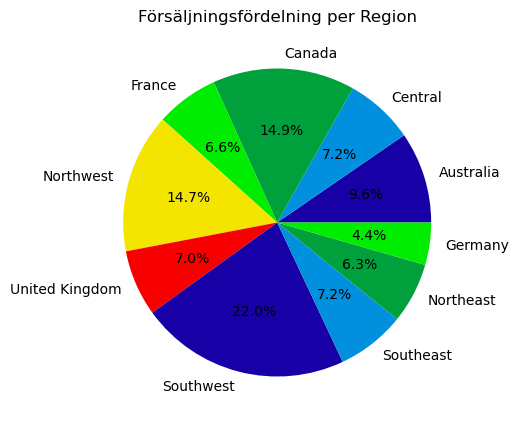

In [60]:
# Pie chart av försäljningar per region, vilken region säljs mest?
plt.figure(figsize=(5, 5))
plt.pie(SalesPerRegion['Total Sales'], labels=SalesPerRegion['Region'], autopct='%1.1f%%')

plt.title('Försäljningsfördelning per Region')

plt.show()

In [61]:
# Total Sales per kategori
KategoriTotalSales = """
    SELECT 
        PC.[Name] AS Kategori  
        , SUM(SOD.LineTotal) AS [Total Sales]
    FROM 
        Sales.SalesOrderDetail AS SOD
            INNER JOIN Production.Product AS P
                ON SOD.ProductID = P.ProductID
    
            INNER JOIN Production.ProductSubcategory AS PSC
                ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
    
            INNER JOIN Production.ProductCategory PC
                ON PSC.ProductCategoryID = PC.ProductCategoryID
    GROUP BY 
        PC.[Name]
    ;
"""
KategoriTotalSales = pd.read_sql(KategoriTotalSales, engine)
KategoriTotalSales['Total Sales'] = KategoriTotalSales['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
KategoriTotalSales

,Kategori,Total Sales
0,Clothing,2120542.52
1,Bikes,94651172.70
2,Accessories,1272072.88
3,Components,11802593.29


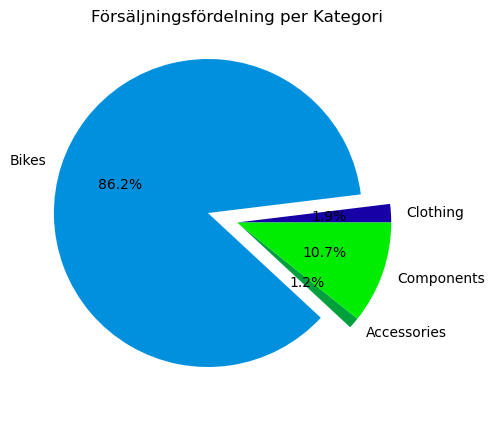

In [62]:
# Visulisera Kategori total sales
plt.figure(figsize=(5, 5))

explode = [0, .2, 0, 0]

plt.pie(KategoriTotalSales['Total Sales'], labels=KategoriTotalSales['Kategori'],\
        autopct='%1.1f%%', explode=explode)
plt.title('Försäljningsfördelning per Kategori')

plt.show()


In [63]:
KategoriRegionTotalSales = """
    SELECT 
        ST.[Name] AS Region 
        , PC.[Name] AS Kategori
        , SUM(SOD.LineTotal) AS [Total Sales]
    FROM 
        Sales.SalesOrderDetail AS SOD
            INNER JOIN Production.Product AS P
                ON SOD.ProductID = P.ProductID
     
             INNER JOIN Production.ProductSubcategory AS PSC
                ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
        
            INNER JOIN Production.ProductCategory AS PC
                ON PSC.ProductCategoryID = PC.ProductCategoryID
        
            INNER JOIN Sales.SalesOrderHeader AS SOH
                ON SOD.SalesOrderID = SOH.SalesOrderID
        
            INNER JOIN Sales.SalesTerritory AS ST
                ON SOH.TerritoryID = ST.TerritoryID
    GROUP BY 
        ST.[Name] 
        , PC.[Name]
    ORDER BY 
        ST.[Name]
        , [Total Sales] DESC
    ;
"""
KategoriRegionTotalSales = pd.read_sql(KategoriRegionTotalSales, engine)
KategoriRegionTotalSales['Total Sales'] = KategoriRegionTotalSales['Total Sales'].apply(lambda x: \
                                                                                        '{:.2f}'.format(x))
KategoriRegionTotalSales

,Region,Kategori,Total Sales
0,Australia,Bikes,10175870.74
1,Australia,Components,203651.31
2,Australia,Accessories,162638.16
3,Australia,Clothing,113175.75
4,Canada,Bikes,13457682.98
5,Canada,Components,2244470.02
6,Canada,Clothing,432112.25
7,Canada,Accessories,221505.20
8,Central,Bikes,6761069.95
9,Central,Components,947404.83


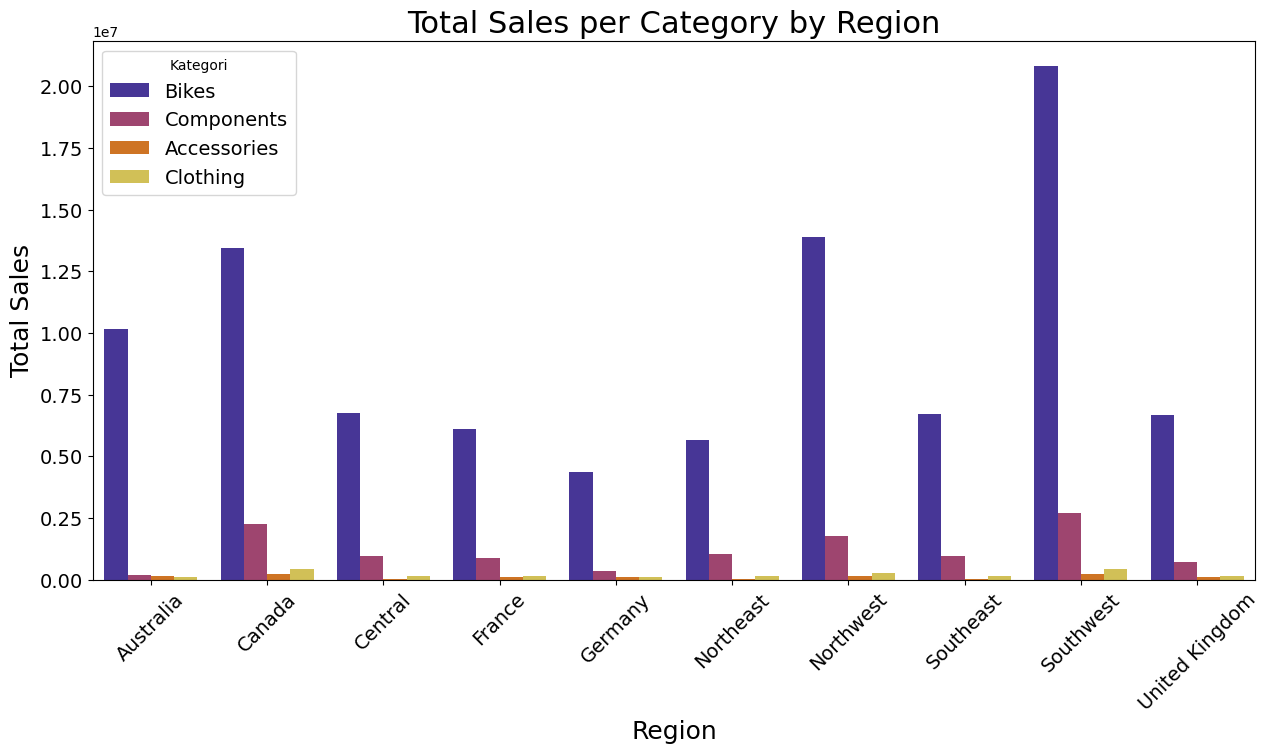

In [64]:
# Visulisera Kategori per Region Total Sales
KategoriRegionTotalSales['Total Sales'] = KategoriRegionTotalSales['Total Sales'].astype(float)

plt.figure(figsize=(15, 7))
sns.barplot(data=KategoriRegionTotalSales, x='Region', y='Total Sales', hue='Kategori', palette='CMRmap')

plt.title('Total Sales per Category by Region', fontsize=22)

plt.xlabel('Region', fontsize=18)
plt.xticks(rotation=45, fontsize=14)  

plt.ylabel('Total Sales', fontsize=18)
plt.yticks(fontsize=14)

plt.legend(title='Kategori', fontsize=14)

plt.show()


In [65]:
# Kundbas lojal > 5 order och nya kunder per Region
KundbasRegion = """
    SELECT 
        C.CustomerID AS [Kund ID]
        , CASE 
            WHEN COUNT(SOH.SalesOrderID) > 5 THEN 'Loyal'
            ELSE 'New'
        END AS [Kund Typ]
        , COUNT(SOH.SalesOrderID) AS [Antal Order]
        , SUM(SOH.TotalDue) AS [Total Sales]
        , ST.[Name] AS Region
    FROM 
        Sales.SalesOrderHeader AS SOH
            INNER JOIN Sales.Customer AS C 
                ON SOH.CustomerID = C.CustomerID

            INNER JOIN Sales.SalesTerritory AS ST
                ON SOH.TerritoryID = ST.TerritoryID
    GROUP BY 
        ST.[Name]
        , C.CustomerID
    ORDER BY
          Region
    ;
"""
KundbasRegion = pd.read_sql(KundbasRegion, engine)
KundbasRegion.head(50)

,Kund ID,Kund Typ,Antal Order,Total Sales,Region
0,11000,New,3,9115.1341,Australia
1,11001,New,3,7054.1875,Australia
2,11002,New,3,8966.0143,Australia
3,11003,New,3,8993.9155,Australia
4,11004,New,3,9056.5911,Australia
5,11005,New,3,8974.0698,Australia
6,11006,New,3,8971.5283,Australia
7,11007,New,3,9073.1551,Australia
8,11008,New,3,8957.4726,Australia
9,11009,New,3,8940.9197,Australia


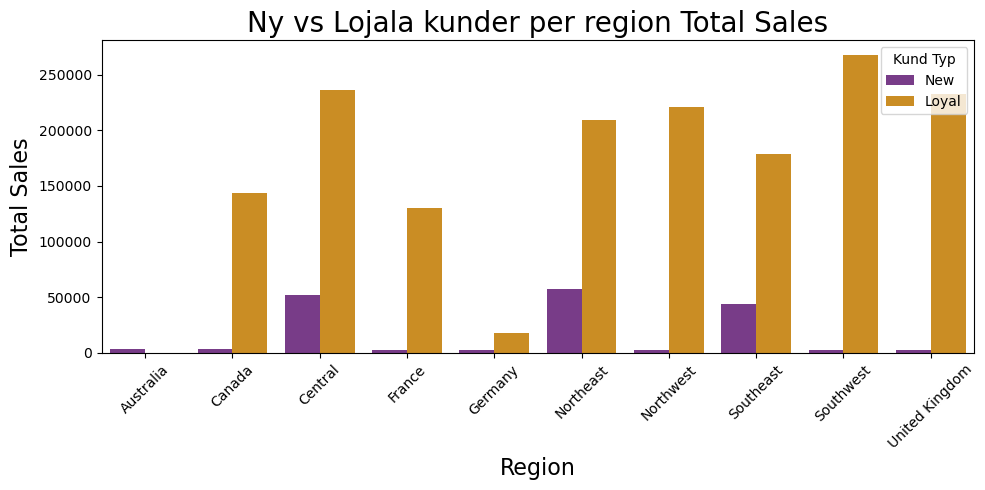

In [66]:
# Visulisera Ny vs Lojala kunder per region Total Sales
plt.figure(figsize=(10, 5))
sns.barplot(data=KundbasRegion, x='Region', y='Total Sales', hue='Kund Typ', palette='CMRmap', errorbar=None)

plt.title('Ny vs Lojala kunder per region Total Sales', fontsize=20)

plt.xlabel('Region', fontsize=16)
plt.xticks(rotation=45)

plt.ylabel('Total Sales', fontsize=16)

plt.legend(title='Kund Typ', loc='upper right')  

plt.tight_layout()
plt.show()

In [67]:
# Hur ser nya och lojal kunder ut bland individer och återförsäljare? 
KundKategoriKundTypSales = """
    WITH KundKategori AS (
        SELECT 
            C.CustomerID
            , CASE 
                WHEN COUNT(SOH.SalesOrderID) > 5 THEN 'Lojal'
                ELSE 'Ny'
            END AS [Kund Kategori]
        FROM 
            Sales.SalesOrderHeader AS SOH
                INNER JOIN Sales.Customer AS C 
                    ON SOH.CustomerID = C.CustomerID
        GROUP BY 
            C.CustomerID
    )

    SELECT 
        KK.[Kund Kategori]
        , CASE 
            WHEN C.StoreID IS NOT NULL THEN 'Återförsäljare'
            ELSE 'Individ'
        END AS [Kund Typ]
        , COUNT(SOH.SalesOrderID) AS [Antal Order]
        , SUM(SOH.TotalDue) AS [Total Sales]
    FROM 
        Sales.SalesOrderHeader AS SOH
            INNER JOIN Sales.Customer AS C 
                ON SOH.CustomerID = C.CustomerID
    
            INNER JOIN KundKategori AS KK 
                ON C.CustomerID = KK.CustomerID
    GROUP BY 
        KK.[Kund Kategori]
        , CASE 
            WHEN C.StoreID IS NOT NULL THEN 'Återförsäljare'
            ELSE 'Individ'
        END
    ;
"""
KundKategoriKundTypSales = pd.read_sql(KundKategoriKundTypSales, engine)
KundKategoriKundTypSales['Total Sales'] = KundKategoriKundTypSales['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
KundKategoriKundTypSales

,Kund Kategori,Kund Typ,Antal Order,Total Sales
0,Ny,Individ,26880,32291928.20
1,Lojal,Återförsäljare,2585,64997814.56
2,Ny,Återförsäljare,1221,25777632.43
3,Lojal,Individ,779,149410.93


In [68]:
# Sales per månad
SalesPerMånad = """
    SELECT 
        FORMAT(SOH.OrderDate, 'yyyy-MM') AS [Order Month]
        , SUM(SOH.TotalDue) AS [Total Sales]
    FROM 
        Sales.SalesOrderHeader AS SOH
    GROUP BY 
        FORMAT(SOH.OrderDate, 'yyyy-MM')
    ORDER BY
        FORMAT(SOH.OrderDate, 'yyyy-MM');
    ;
"""
SalesPerMånad = pd.read_sql(SalesPerMånad, engine)
SalesPerMånad['Total Sales'] = SalesPerMånad['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
SalesPerMånad

,Order Month,Total Sales
0,2011-05,567020.95
1,2011-06,507096.47
2,2011-07,2292182.88
3,2011-08,2800576.17
4,2011-09,554791.61
5,2011-10,5156269.53
6,2011-11,815313.02
7,2011-12,1462448.90
8,2012-01,4458337.44
9,2012-02,1649051.90


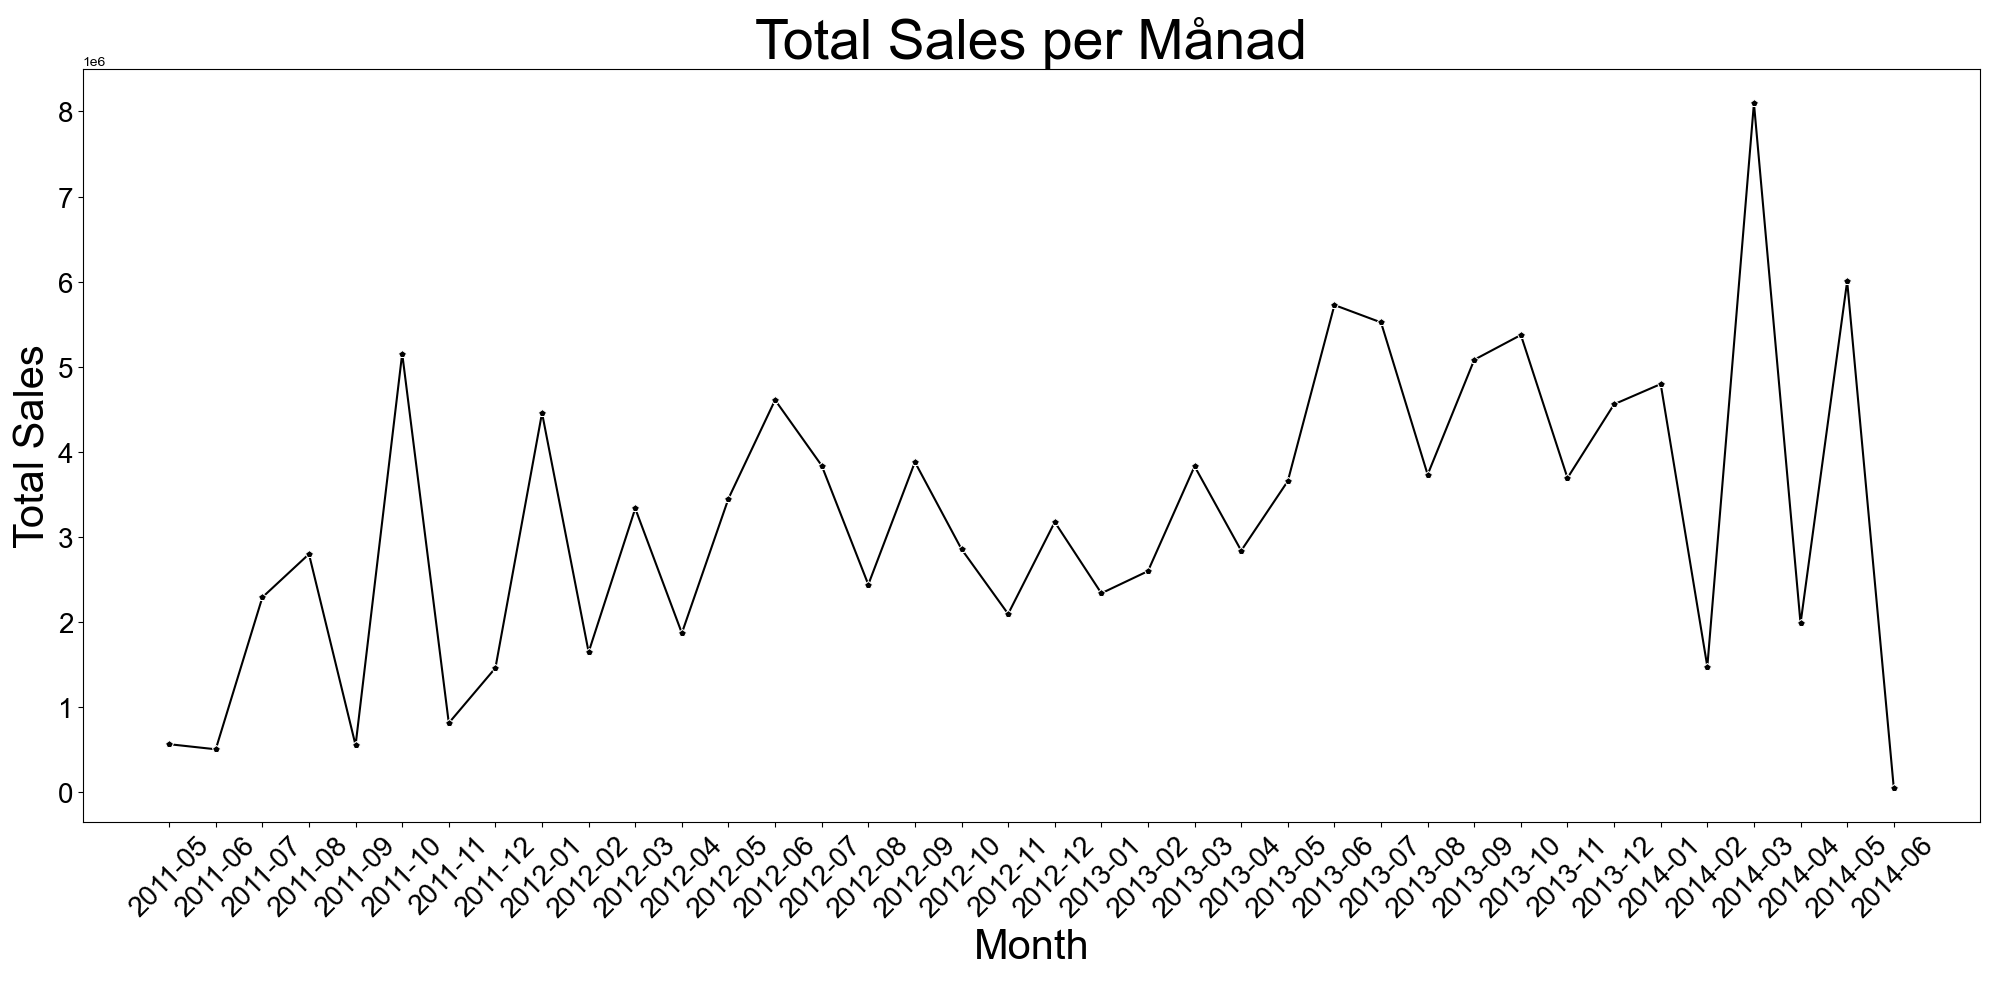

In [69]:
# Diagram Total Sales per månad
# ändra sales tillbaka till float
SalesPerMånad['Total Sales'] = SalesPerMånad['Total Sales'].astype(float)

plt.figure(figsize=(20, 10))
sns.lineplot(data= SalesPerMånad, x='Order Month', y='Total Sales', color='black', marker='p')

plt.title('Total Sales per Månad', fontsize=40)

plt.xlabel('Month', fontsize=30)
plt.xticks(rotation=45, fontsize=20)

plt.ylabel('Total Sales', fontsize=30)
plt.yticks(fontsize=20)

plt.tight_layout()
sns.set_style("whitegrid")
plt.show()


In [70]:
# Sales per Kvartal
SalesPerKvartal = """ 
    SELECT 
        YEAR(OrderDate) AS År 
        , DATEPART(QUARTER, OrderDate) AS Kvartal
        , SUM(SubTotal) AS [Total Sales]
    FROM Sales.SalesOrderHeader
    
    GROUP BY 
        YEAR(OrderDate)
        , DATEPART(QUARTER, OrderDate)
    ORDER BY 
        År
        , Kvartal
    ;
"""
SalesPerKvartal = pd.read_sql(SalesPerKvartal, engine)
SalesPerKvartal['Total Sales'] = SalesPerKvartal['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
SalesPerKvartal

,År,Kvartal,Total Sales
0,2011,2,962716.74
1,2011,3,5042490.58
2,2011,4,6636464.89
3,2012,1,8421802.43
4,2012,2,8808557.97
5,2012,3,9047743.03
6,2012,4,7246197.90
7,2013,1,7816863.58
8,2013,2,10858958.80
9,2013,3,12763226.51


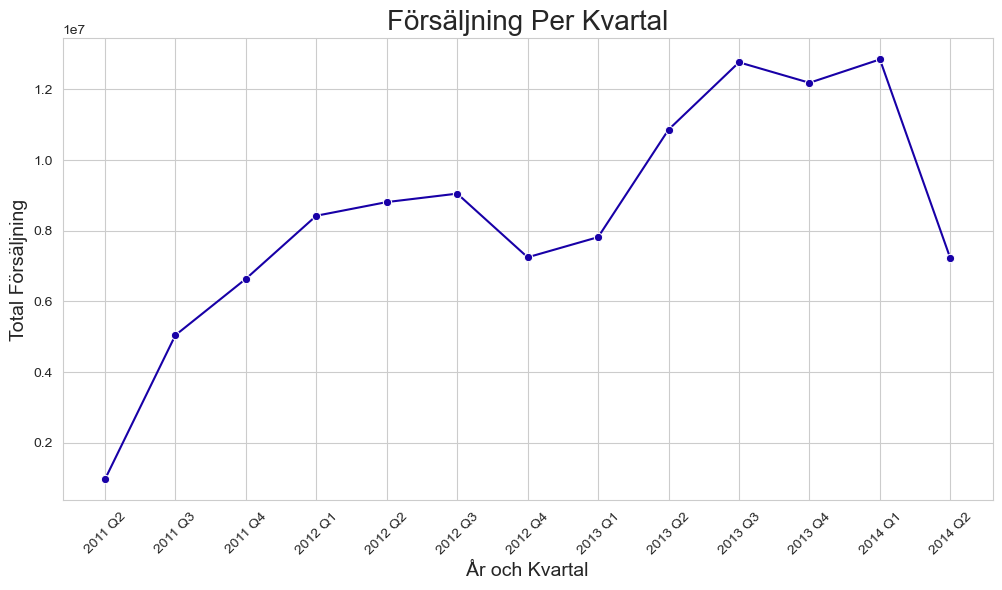

In [71]:
# Visulisera Total Sales på lineplot
# Konvertera År och Kvartal till en sträng för att skapa en tidsaxel
SalesPerKvartal['År Kvartal'] = SalesPerKvartal['År'].astype(str) + " Q" + SalesPerKvartal['Kvartal'].astype(str)
SalesPerKvartal['Total Sales'] = SalesPerKvartal['Total Sales'].astype(float)

plt.figure(figsize=(12, 6))
sns.lineplot(x='År Kvartal', y='Total Sales', data=SalesPerKvartal, marker='o')

plt.title('Försäljning Per Kvartal', fontsize=20)

plt.xlabel('År och Kvartal', fontsize=14)
plt.xticks(rotation=45)

plt.ylabel('Total Försäljning', fontsize=14)

plt.show()

In [72]:
#Total sales per anställd
TotalSalesAnställd = """
    SELECT 
        sp.BusinessEntityID AS [Anställdsnummer] 
        , P.FirstName + ' ' + P.LastName AS Anställd
        , SUM(soh.TotalDue) AS [Total Sales]
    FROM 
        Sales.SalesOrderHeader AS SOH
            INNER JOIN Sales.SalesPerson AS SP 
                ON SOH.SalesPersonID = SP.BusinessEntityID
            INNER JOIN Person.Person AS P 
                ON SP.BusinessEntityID = P.BusinessEntityID
    GROUP BY 
        SP.BusinessEntityID
        , P.FirstName
        , P.LastName
    ORDER BY
        [Total Sales]
    ;
"""
TotalSalesAnställd = pd.read_sql(TotalSalesAnställd, engine)
TotalSalesAnställd['Total Sales'] = TotalSalesAnställd['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
TotalSalesAnställd

,Anställdsnummer,Anställd,Total Sales
0,285,Syed Abbas,195528.78
1,287,Amy Alberts,826417.47
2,274,Stephen Jiang,1235934.45
3,286,Lynn Tsoflias,1606441.45
4,288,Rachel Valdez,2062393.14
5,284,Tete Mensa-Annan,2608116.38
6,280,Pamela Ansman-Wolfe,3748246.12
7,278,Garrett Vargas,4069422.21
8,283,David Campbell,4207894.60
9,290,Ranjit Varkey Chudukatil,5087977.21


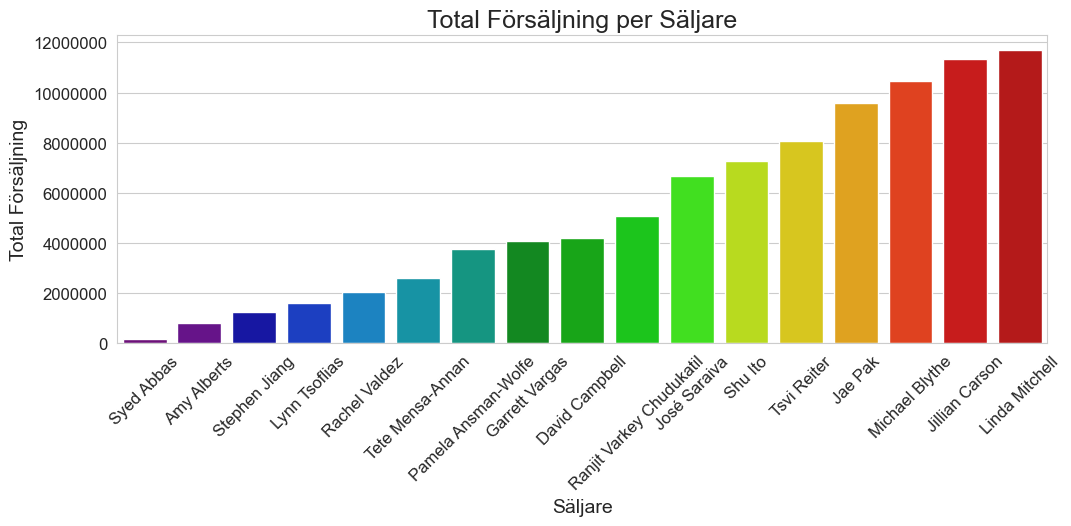

In [73]:
TotalSalesAnställd['Total Sales'] = TotalSalesAnställd['Total Sales'].astype(float)

plt.figure(figsize=(12, 4))
sns.barplot(x='Anställd', y='Total Sales', data=TotalSalesAnställd, hue='Anställd',\
            palette='nipy_spectral')

plt.title('Total Försäljning per Säljare', fontsize=18)

plt.xlabel('Säljare', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.ylabel('Total Försäljning', fontsize=14)
plt.yticks([0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000],\
           [0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000], fontsize=12)

plt.show()

In [74]:
# Försäljare Total Sales Per År

FörsäljareTotalSalesÅr = """ 
   SELECT 
        E.BusinessEntityID AS Anställningsnummer
        , P.FirstName AS Förnamn
        , P.LastName AS Efternamn
        , YEAR(SOH.OrderDate) AS [Sales År]
        , SUM(SOH.SubTotal) AS [Total Sales]  
    FROM 
        HumanResources.Employee AS E
            INNER JOIN Person.Person AS P
                ON E.BusinessEntityID = P.BusinessEntityID
            INNER JOIN Sales.SalesOrderHeader AS SOH
                ON E.BusinessEntityID = SOH.SalesPersonID
    GROUP BY 
        E.BusinessEntityID
        , P.FirstName
        , P.LastName
        , YEAR(SOH.OrderDate)
    ORDER BY 
        [Sales År]
    ;
"""
FörsäljareTotalSalesÅr = pd.read_sql(FörsäljareTotalSalesÅr, engine)
FörsäljareTotalSalesÅr['Total Sales'] = FörsäljareTotalSalesÅr['Total Sales'].apply(lambda x: '{:.2f}'.format(x))
FörsäljareTotalSalesÅr

,Anställningsnummer,Förnamn,Efternamn,Sales År,Total Sales
0,279,Tsvi,Reiter,2011,1521289.19
1,281,Shu,Ito,2011,967597.29
2,274,Stephen,Jiang,2011,28926.25
3,276,Linda,Mitchell,2011,1149715.33
4,278,Garrett,Vargas,2011,500091.82
5,283,David,Campbell,2011,599987.94
6,275,Michael,Blythe,2011,875823.83
7,280,Pamela,Ansman-Wolfe,2011,648485.59
8,282,José,Saraiva,2011,1175007.48
9,277,Jillian,Carson,2011,1311627.29


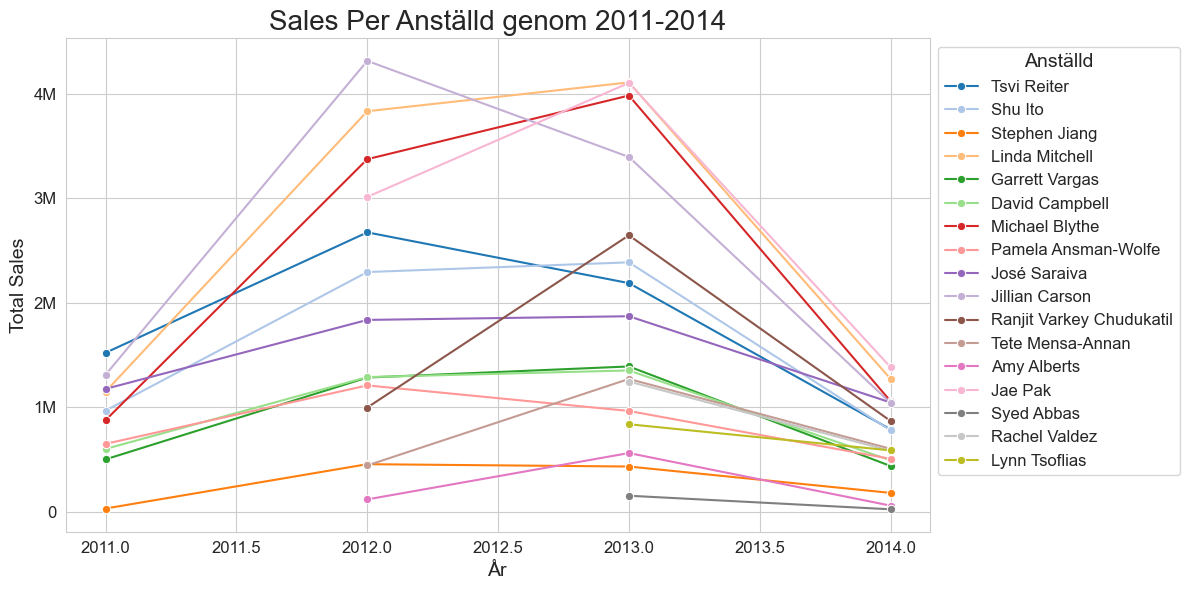

In [75]:
# Linediagram Försäljare Total Sales Per År
FörsäljareTotalSalesÅr['Anställds Namn'] = FörsäljareTotalSalesÅr['Förnamn'] + \
                                            ' ' + FörsäljareTotalSalesÅr['Efternamn']
FörsäljareTotalSalesÅr['Total Sales'] = FörsäljareTotalSalesÅr['Total Sales'].astype(float)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Sales År', y='Total Sales', hue='Anställds Namn', data=FörsäljareTotalSalesÅr,\
             marker='o', palette='tab20')

plt.title('Sales Per Anställd genom 2011-2014', fontsize=20)

plt.xlabel('År', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Total Sales', fontsize= 14)
plt.yticks([0, 1000000, 2000000, 3000000, 4000000], ['0', '1M', '2M', '3M', '4M'], fontsize=12)

plt.legend(title='Anställd', title_fontsize=14, bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.grid(True)
plt.show()

In [76]:
# Antal Produkter sålt antingen i en affär eller till individer
ProduktKanalSålt = """
    SELECT 
        CASE 
            WHEN C.StoreID IS NOT NULL THEN 'Återförsäljare'
            ELSE 'Individ'
        END AS [Kund Typ]
        , P.[Name] AS Produkt
        , SUM(SOD.OrderQty) AS [Total Beställda]
    FROM 
        Sales.SalesOrderHeader AS SOH
            INNER JOIN Sales.SalesOrderDetail AS SOD 
                ON SOH.SalesOrderID = SOD.SalesOrderID

            INNER JOIN Production.Product AS P 
                ON SOD.ProductID = P.ProductID

            INNER JOIN Sales.Customer AS C 
                ON SOH.CustomerID = C.CustomerID

    GROUP BY 
        CASE 
            WHEN C.StoreID IS NOT NULL THEN 'Återförsäljare'
            ELSE 'Individ'
        END 
        , P.[Name]
		 
    ORDER BY 
        [Kund Typ]
;
"""
ProduktKanalSålt = pd.read_sql(ProduktKanalSålt, engine)
ProduktKanalSålt

,Kund Typ,Produkt,Total Beställda
0,Återförsäljare,"Long-Sleeve Logo Jersey, XL",2567
1,Återförsäljare,"HL Road Frame - Red, 62",485
2,Återförsäljare,"HL Road Frame - Red, 44",486
3,Återförsäljare,"HL Road Frame - Red, 48",109
4,Återförsäljare,"LL Road Frame - Black, 58",940
...,...,...,...
375,Individ,AWC Logo Cap,2190
376,Individ,"Long-Sleeve Logo Jersey, S",429
377,Individ,"Sport-100 Helmet, Black",2085
378,Individ,"Sport-100 Helmet, Red",2230


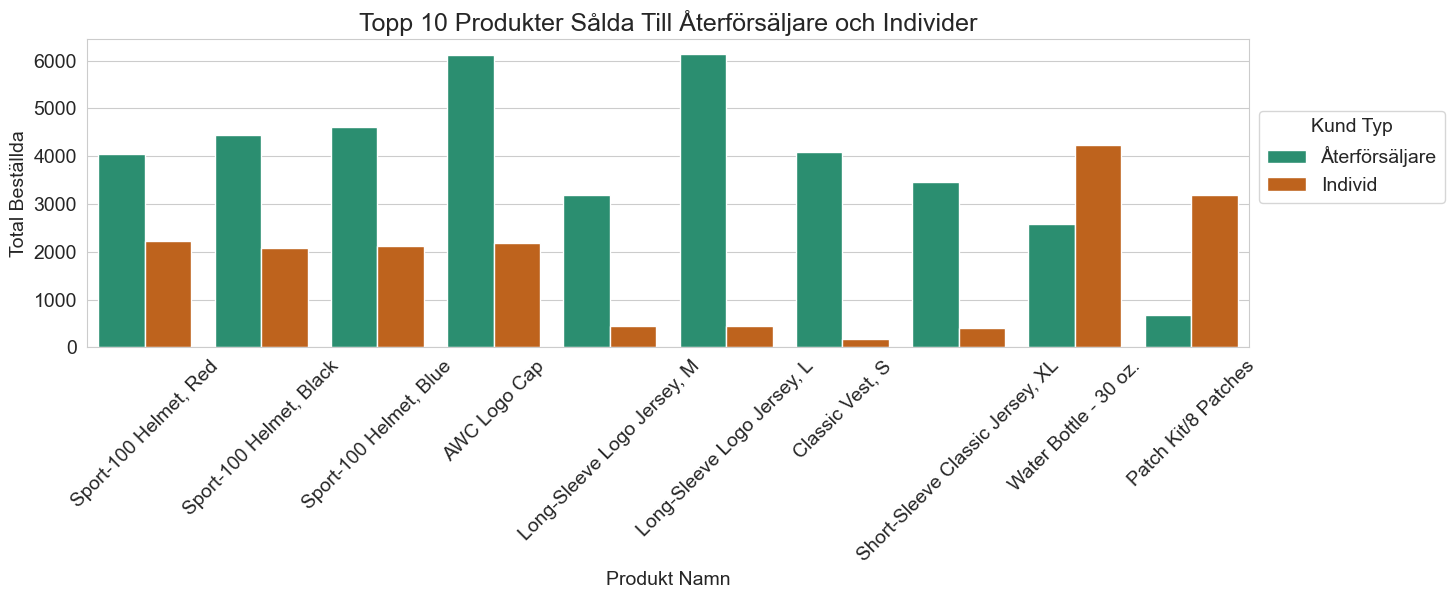

In [77]:
top_produkter = ProduktKanalSålt.groupby('Produkt')['Total Beställda'].sum().nlargest(10)
ProduktKanalSålt_Modifierad = ProduktKanalSålt[ProduktKanalSålt['Produkt'].isin(top_produkter.index)]

plt.figure(figsize=(15,4))
sns.barplot(x='Produkt', y='Total Beställda', hue='Kund Typ', data=ProduktKanalSålt_Modifierad, palette='Dark2')

plt.title("Topp 10 Produkter Sålda Till Återförsäljare och Individer", fontsize=18)

plt.xlabel("Produkt Namn", fontsize=14)
plt.xticks(rotation=45, fontsize=14)

plt.ylabel("Total Beställda", fontsize=14)
plt.yticks(fontsize=14)

plt.legend(title="Kund Typ", title_fontsize=14, fontsize=14, bbox_to_anchor=(1, .8))

plt.show()


In [78]:
# Topp 3 produkter sålt i en affär och topp 3 produkter sålt online , total sales
TotalSalesProdukterPerKanal = """
    WITH SalesKanal
    AS (
        SELECT 
            SOD.ProductID, 
            SOH.OnlineOrderFlag,
            SUM(SOD.LineTotal) AS [Total Sales]
        FROM 
            Sales.SalesOrderDetail AS SOD
                INNER JOIN Sales.SalesOrderHeader AS SOH 
                    ON SOD.SalesOrderID = SOH.SalesOrderID
    
        GROUP BY 
            SOD.ProductID
            , SOH.OnlineOrderFlag
    ),

    RankedProdukter
    AS (
        SELECT 
            SK.ProductID
            , P.[Name] AS Produkt
            , CASE 
                WHEN SK.OnlineOrderFlag = 1 
                    THEN 'Online' 
                    ELSE 'In-Store' 
                END AS [Sales Kanal]
            , SK.[Total Sales]
            , RANK() OVER (PARTITION BY SK.OnlineOrderFlag ORDER BY SK.[Total Sales] DESC) AS SalesRank
    
        FROM 
            SalesKanal AS SK
                INNER JOIN Production.Product AS P
                    ON SK.ProductID = P.ProductID
    )

    SELECT 
        ProductID
        , Produkt
        , [Sales Kanal]
        , [Total Sales]

    FROM RankedProdukter

    WHERE SalesRank <= 3
    ;
"""
TotalSalesProdukterPerKanal = pd.read_sql(TotalSalesProdukterPerKanal, engine)
TotalSalesProdukterPerKanal['Total Sales'] = TotalSalesProdukterPerKanal['Total Sales'].apply(lambda x: \
                                                                                    '{:.2f}'.format(x))
TotalSalesProdukterPerKanal

,ProductID,Produkt,Sales Kanal,Total Sales
0,782,"Mountain-200 Black, 38",In-Store,3105726.66
1,783,"Mountain-200 Black, 42",In-Store,2646352.67
2,779,"Mountain-200 Silver, 38",In-Store,2354215.23
3,784,"Mountain-200 Black, 46",Online,1373469.55
4,783,"Mountain-200 Black, 42",Online,1363142.09
5,779,"Mountain-200 Silver, 38",Online,1339462.79


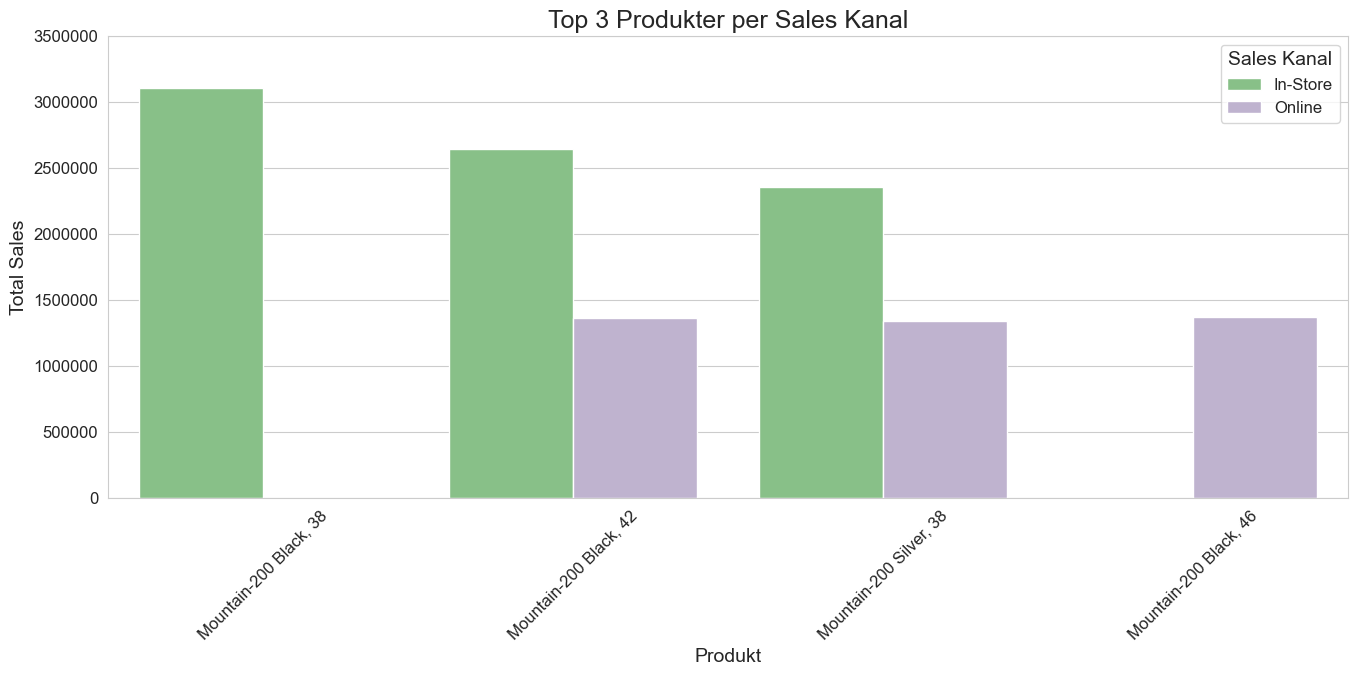

In [79]:
# Visulisera topp 3 produkter och kanalar dem säljs i

# Ändra 'Total Sales' tillbaka till float
TotalSalesProdukterPerKanal['Total Sales'] = TotalSalesProdukterPerKanal['Total Sales'].astype(float)

plt.figure(figsize=(16, 6))
sns.barplot(data=TotalSalesProdukterPerKanal, x='Produkt', y='Total Sales', 
            hue='Sales Kanal' , palette='Accent')

plt.xlabel('Produkt', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.ylabel('Total Sales', fontsize=14)
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000],\
           [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000], fontsize=12)

plt.title('Top 3 Produkter per Sales Kanal', fontsize=18)

plt.legend(title='Sales Kanal', title_fontsize=14, \
           fontsize=12, bbox_to_anchor=(1, 1))

plt.show()

In [80]:
# Topp 5 produkter som säljs tillsammans
ToppProdukterSåltSomPar = """
    WITH ProduktPar AS 
    (
        SELECT 
            SalesOrder1.ProductID AS [Produkt ID 1]
            , SalesOrder2.ProductID AS [Produkt ID 2]
        FROM 
            Sales.SalesOrderDetail AS SalesOrder1
                INNER JOIN Sales.SalesOrderDetail AS SalesOrder2
                    ON SalesOrder1.SalesOrderID = SalesOrder2.SalesOrderID
        WHERE 
            SalesOrder1.ProductID < SalesOrder2.ProductID
    ),

    RankedProduktPar AS
    (
        SELECT 
            [Produkt ID 1]
            , [Produkt ID 2]
            , DENSE_RANK() OVER (ORDER BY COUNT(*) DESC) AS Rank
            , COUNT(*) AS SåltTillsammans
        FROM ProduktPar
        GROUP BY 
            [Produkt ID 1]
            , [Produkt ID 2]
    )

    SELECT 
        RPP.[Produkt ID 1]
        , P1.[Name] AS [Produkt Namn 1]
        , RPP.[Produkt ID 2]
        , P2.[Name] AS [Produkt Namn 2]
        , RPP.SåltTillsammans
    FROM 
        RankedProduktPar AS RPP
            INNER JOIN Production.Product AS P1
                ON RPP.[Produkt ID 1] = P1.ProductID
            
            INNER JOIN Production.Product AS P2
                ON RPP.[Produkt ID 2] = P2.ProductID
    WHERE RPP.Rank <= 5
    ORDER BY RPP.Rank
    ;
"""
ToppProdukterSåltSomPar=pd.read_sql(ToppProdukterSåltSomPar, engine)
ToppProdukterSåltSomPar

,Produkt ID 1,Produkt Namn 1,Produkt ID 2,Produkt Namn 2,SåltTillsammans
0,870,Water Bottle - 30 oz.,871,Mountain Bottle Cage,1692
1,870,Water Bottle - 30 oz.,872,Road Bottle Cage,1521
2,712,AWC Logo Cap,715,"Long-Sleeve Logo Jersey, L",1172
3,712,AWC Logo Cap,870,Water Bottle - 30 oz.,1019
4,711,"Sport-100 Helmet, Blue",712,AWC Logo Cap,1011


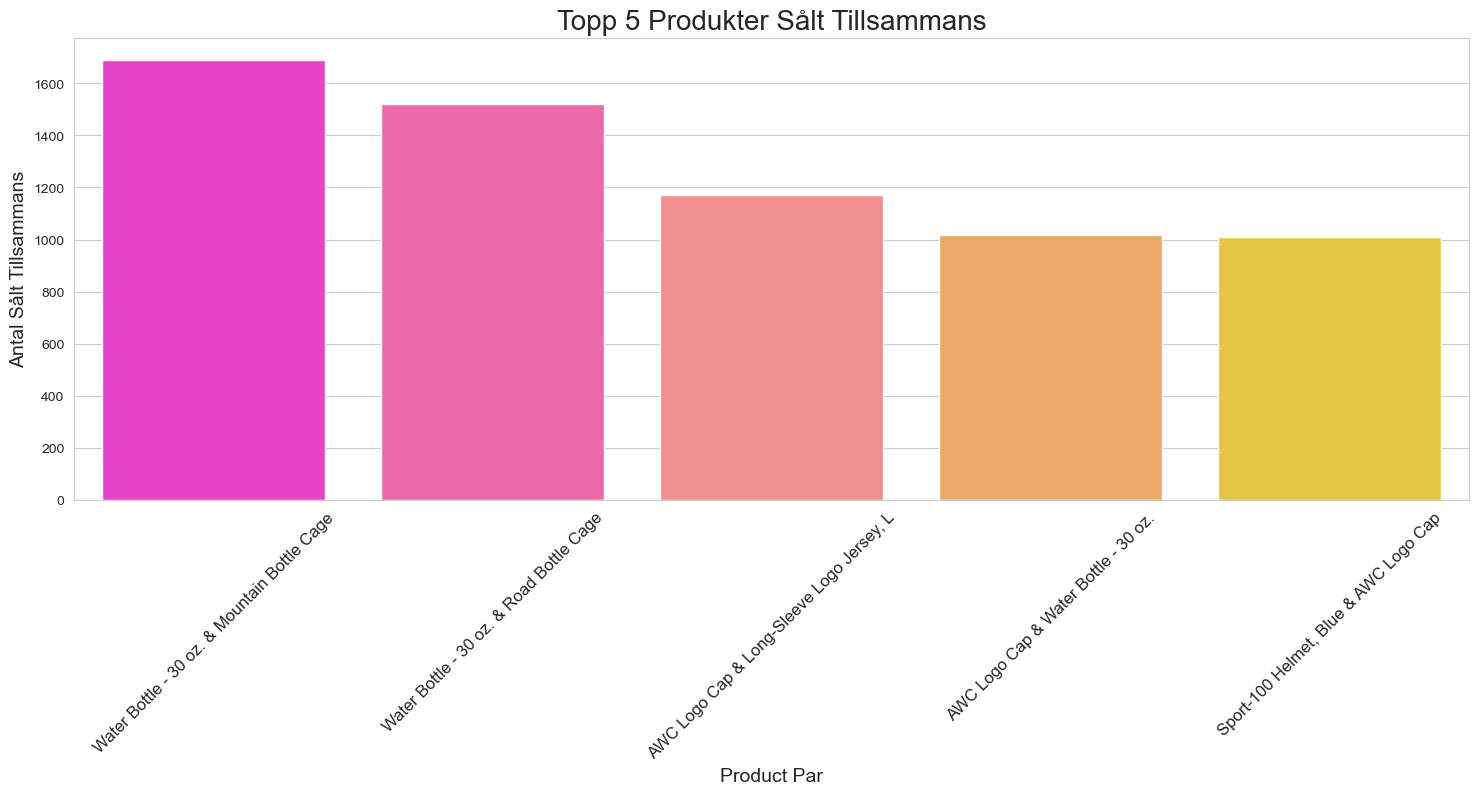

In [81]:
ToppProdukterSåltSomPar['Produkt Par'] = ToppProdukterSåltSomPar['Produkt Namn 1'] + \
                                            " & " + ToppProdukterSåltSomPar['Produkt Namn 2']
plt.figure(figsize=(18, 6))
sns.barplot(x='Produkt Par', y='SåltTillsammans', data=ToppProdukterSåltSomPar, hue='Produkt Par', \
                                                                                        palette='spring')

plt.xlabel('Product Par', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.ylabel('Antal Sålt Tillsammans', fontsize=14)

plt.title('Topp 5 Produkter Sålt Tillsammans', fontsize=20)

plt.show()

In [82]:
KampanjKategoriSales = """
    SELECT 
        SOD.SalesOrderID AS [Sales Order ID]
        , SOD.ProductID AS [Produkt ID]
        , SOD.OrderQty AS [Order Antal]
        , SOH.TotalDue AS [Total Sales]
        , SO.DiscountPct AS [Rea %]
        , SO.Type AS [Kampanj]
        ,SO.Category AS [Kategori]
    FROM 
        Sales.SalesOrderDetail SOD
            INNER JOIN Sales.SalesOrderHeader AS SOH 
                ON SOD.SalesOrderID = SOH.SalesOrderID

            INNER JOIN Sales.SpecialOfferProduct AS SOP 
                ON SOD.ProductID = SOP.ProductID

            INNER JOIN Sales.SpecialOffer AS SO 
                ON SOP.SpecialOfferID = SO.SpecialOfferID
        ;
"""
KampanjKategoriSales = pd.read_sql(KampanjKategoriSales, engine)
KampanjKategoriSales

,Sales Order ID,Produkt ID,Order Antal,Total Sales,Rea %,Kampanj,Kategori
0,43659,776,1,23153.2339,0.00,No Discount,No Discount
1,43659,776,1,23153.2339,0.02,Volume Discount,Reseller
2,43659,776,1,23153.2339,0.35,Discontinued Product,Reseller
3,43659,777,3,23153.2339,0.00,No Discount,No Discount
4,43659,777,3,23153.2339,0.02,Volume Discount,Reseller
...,...,...,...,...,...,...,...
296978,75123,879,1,209.9169,0.00,No Discount,No Discount
296979,75123,712,1,209.9169,0.00,No Discount,No Discount
296980,75123,712,1,209.9169,0.02,Volume Discount,Reseller
296981,75123,712,1,209.9169,0.05,Volume Discount,Reseller


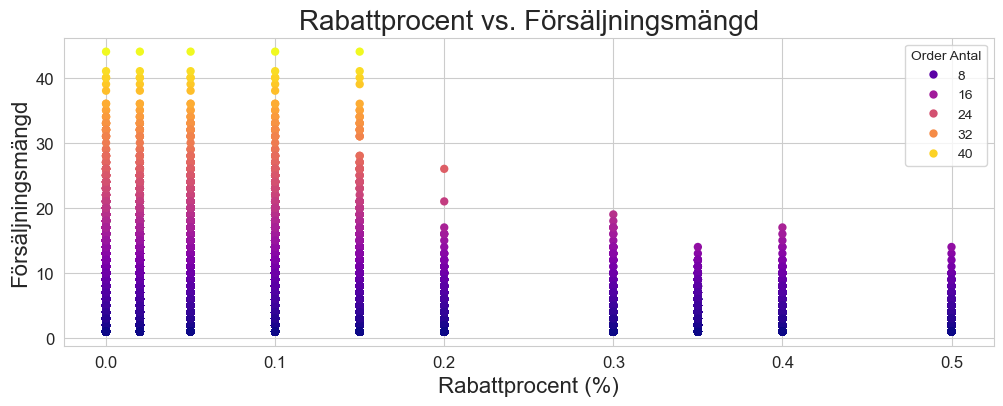

In [83]:
# Rabattprocent vs. Försäljningsmängd
plt.figure(figsize=(12, 4))
sns.scatterplot(x='Rea %', y='Order Antal', data=KampanjKategoriSales, hue= 'Order Antal',\
                                                                palette='plasma', edgecolor='none')

plt.title('Rabattprocent vs. Försäljningsmängd', fontsize=20)

plt.xlabel('Rabattprocent (%)', fontsize= 16)
plt.xticks(fontsize=12)

plt.ylabel('Försäljningsmängd', fontsize=16)
plt.yticks(fontsize=12)

plt.show()

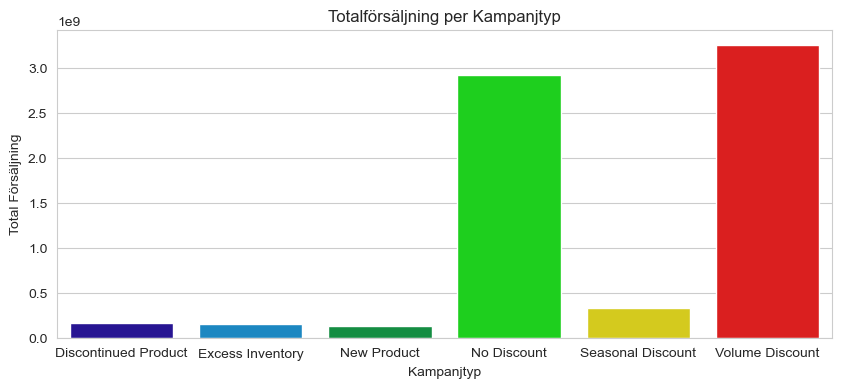

In [100]:
plt.figure(figsize=(10, 4))
TotalSales_Kampanj = KampanjKategoriSales.groupby('Kampanj')['Total Sales'].sum().reset_index()
sns.barplot(x='Kampanj', y='Total Sales', data=TotalSales_Kampanj, hue='Kampanj', palette='nipy_spectral')

plt.title('Totalförsäljning per Kampanjtyp')

plt.xlabel('Kampanjtyp')

plt.ylabel('Total Försäljning')

plt.show()



In [85]:
# Beräkna korrelationskoefficient mellan 'Rea %' och 'Order Antal'
correlation_value = KampanjKategoriSales['Rea %'].corr(KampanjKategoriSales['Order Antal'])

print(f'Korrelationskoefficienten är: {correlation_value}')


Korrelationskoefficienten är: -0.013273723049176962


In [86]:
KampanjEffekt = """
    SELECT 
        SO.Description AS KampanjTyp
        , SO.SpecialOfferID
        , SOP.ProductID AS [Produkt ID]
        , SO.StartDate AS [Kampanj Start]
        , SO.EndDate AS [Kampanj Slut]
        , SUM(SOD.LineTotal) AS [Kampanj Sales]
        , SalesNästaPeriod.[Normal Sales]
    FROM 
        Sales.SalesOrderDetail AS SOD
            INNER JOIN Sales.SalesOrderHeader AS SOH
                ON SOD.SalesOrderID = SOH.SalesOrderID
    
            INNER JOIN Sales.SpecialOfferProduct AS SOP 
                ON SOD.ProductID = SOP.ProductID
    
            INNER JOIN Sales.SpecialOffer AS SO 
                ON SOP.SpecialOfferID = SO.SpecialOfferID

            LEFT JOIN (
                    SELECT 
                        SOP.ProductID
                        , SO.SpecialOfferID
                        , SUM(SOD.LineTotal) AS [Normal Sales]
                    FROM 
                        Sales.SalesOrderDetail AS SOD
                        
                            INNER JOIN Sales.SalesOrderHeader AS SOH 
                                ON SOD.SalesOrderID = SOH.SalesOrderID
        
                            INNER JOIN Sales.SpecialOfferProduct AS SOP
                                ON SOD.ProductID = SOP.ProductID
        
                            INNER JOIN Sales.SpecialOffer AS SO
                                ON SOP.SpecialOfferID = SO.SpecialOfferID
                     WHERE 
                        SOH.OrderDate BETWEEN DATEADD(YEAR, 1, SO.StartDate) AND
                        DATEADD(YEAR, 1, SO.EndDate)
                    GROUP BY 
                        SOP.ProductID
                        , SO.SpecialOfferID
                    ) AS SalesNästaPeriod 
                        ON SOP.ProductID = SalesNästaPeriod.ProductID AND SO.SpecialOfferID = \
                                                                        SalesNästaPeriod.SpecialOfferID
    WHERE 
        SOH.OrderDate BETWEEN SO.StartDate AND SO.EndDate
        AND SO.Description <> 'No Discount' 
        AND SalesNästaPeriod.[Normal Sales] IS NOT NULL
    GROUP BY 
        SO.Description
        , SO.StartDate
        , SO.EndDate
        , SOP.ProductID
        , SO.SpecialOfferID
        , SalesNästaPeriod.[Normal Sales]
    ORDER BY
        SO.SpecialOfferID
    ;
"""
KampanjEffekt = pd.read_sql(KampanjEffekt, engine) 
#KampanjEffekt['Normal Sales'] = KampanjEffekt['Normal Sales'].apply(lambda x: '{:.2f}'.format(x))
#KampanjEffekt['Kampanj Sales'] = KampanjEffekt['Kampanj Sales'].apply(lambda x: '{:.2f}'.format(x))
KampanjEffekt

,KampanjTyp,SpecialOfferID,Produkt ID,Kampanj Start,Kampanj Slut,Kampanj Sales,Normal Sales
0,Volume Discount 11 to 14,2,969,2011-05-31,2014-05-30,1.721243e+06,1.721243e+06
1,Volume Discount 11 to 14,2,908,2011-05-31,2014-05-30,5.636957e+03,5.636957e+03
2,Volume Discount 11 to 14,2,797,2011-05-31,2014-05-30,1.227910e+06,1.186019e+06
3,Volume Discount 11 to 14,2,961,2011-05-31,2014-05-30,3.581219e+05,3.581219e+05
4,Volume Discount 11 to 14,2,973,2011-05-31,2014-05-30,1.657198e+06,1.657198e+06
...,...,...,...,...,...,...,...
184,Sport Helmet Discount-2003,11,708,2013-05-30,2013-06-29,4.467523e+03,3.219080e+03
185,Sport Helmet Discount-2003,11,711,2013-05-30,2013-06-29,4.986250e+03,3.499000e+03
186,Touring-3000 Promotion,13,961,2013-05-30,2013-08-29,7.209889e+04,7.423500e+02
187,Touring-3000 Promotion,13,978,2013-05-30,2013-08-29,2.928756e+04,7.423500e+02


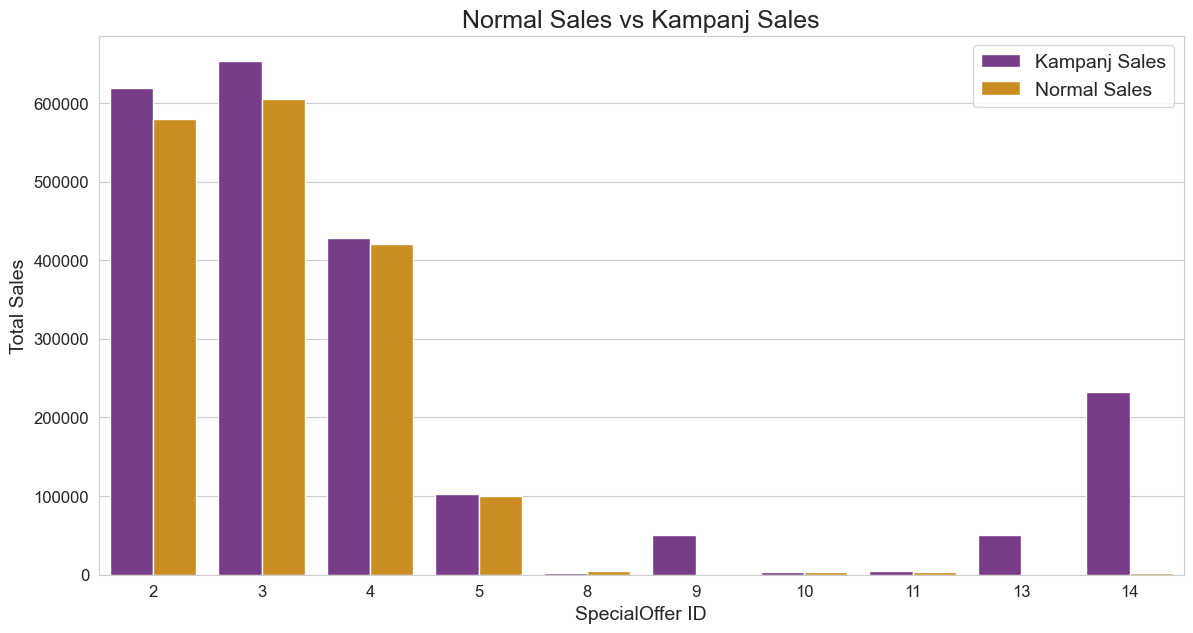

In [87]:
# Förbered datan för diagram och använd SpecialOfferID som identifierare
melted_data = KampanjEffekt.melt(id_vars=['SpecialOfferID'], 
                                 value_vars=['Kampanj Sales', 'Normal Sales'], 
                                 var_name='Sales Type', value_name='Total Sales')
plt.figure(figsize=(14, 7))

sns.barplot(x='SpecialOfferID', y='Total Sales', hue='Sales Type', data=melted_data, \
            errorbar=None, palette='CMRmap')

plt.title('Normal Sales vs Kampanj Sales', fontsize=18)

plt.xlabel('SpecialOffer ID', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Total Sales', fontsize=14)
plt.yticks(fontsize=12)

plt.legend(fontsize=14)

# Visa plotten
plt.show()





In [88]:
# Konfidensintervall för normal sales och kampanj sales
mean_NormalSales = KampanjEffekt['Normal Sales'].mean()
std_NormalSales = KampanjEffekt['Normal Sales'].std()

mean_KampanjSales = KampanjEffekt['Kampanj Sales'].mean()
std_KampanjSales = KampanjEffekt['Kampanj Sales'].std()


nN = KampanjEffekt['Normal Sales'].count()
nK = KampanjEffekt['Kampanj Sales'].count()


ciN = stats.t.interval(0.95 ,df=n-1, loc=mean_NormalSales, scale=std_NormalSales/np.sqrt(nN))
ciK = stats.t.interval(0.95 ,df=n-1, loc=mean_KampanjSales, scale=std_KampanjSales/np.sqrt(nK))

print(f"Konfidensintervallet för Normal Sales medelvärdet av total försäljning är: {ciN}")
print(f"Konfidensintervallet för Kampanj Sales medelvärdet av total försäljning är: {ciK}")



Konfidensintervallet för Normal Sales medelvärdet av total försäljning är: (402483.5336491957, 655098.1520299471)
Konfidensintervallet för Kampanj Sales medelvärdet av total försäljning är: (437101.9102302718, 696499.651717887)


## Inköp och Leverantörshantering

In [89]:
InköpPerMånadToppLeverantör = """
    WITH LeverantörerKostnader 
    AS (
        SELECT 
            V.Name AS Leverantör
            , SUM(POD.LineTotal) AS [Total Inköp Kostnad]
            , AVG(POD.LineTotal) AS [Snitt Kostnad Per Order]
        FROM 
            Purchasing.PurchaseOrderHeader AS POH
                INNER JOIN Purchasing.PurchaseOrderDetail AS POD
                    ON POH.PurchaseOrderID = POD.PurchaseOrderID
            
                INNER JOIN Purchasing.Vendor AS V
                    ON POH.VendorID = V.BusinessEntityID
        GROUP BY 
            V.Name
    )

    SELECT TOP (10) 
        Leverantör
        , [Total Inköp Kostnad]
        , [Snitt Kostnad Per Order]
    FROM 
        LeverantörerKostnader
    ORDER BY 
        [Total Inköp Kostnad] DESC
    ;
"""
InköpPerMånadToppLeverantör =pd.read_sql(InköpPerMånadToppLeverantör,engine)
InköpPerMånadToppLeverantör

,Leverantör,Total Inköp Kostnad,Snitt Kostnad Per Order
0,Superior Bicycles,4555897.500,45558.9750
1,Professional Athletic Consultants,3058774.950,21540.6686
2,Chicago City Saddles,3029108.775,16922.3953
3,Jackson Authority,2553243.000,21277.0250
4,"Vision Cycles, Inc.",2513742.000,20947.8500
5,Sport Fan Co.,2421619.200,20697.6000
6,"Proseware, Inc.",2347422.000,19561.8500
7,Greenwood Athletic Company,2237800.950,21939.2250
8,Crowley Sport,2237800.950,21939.2250
9,Mitchell Sports,2193922.500,21939.2250


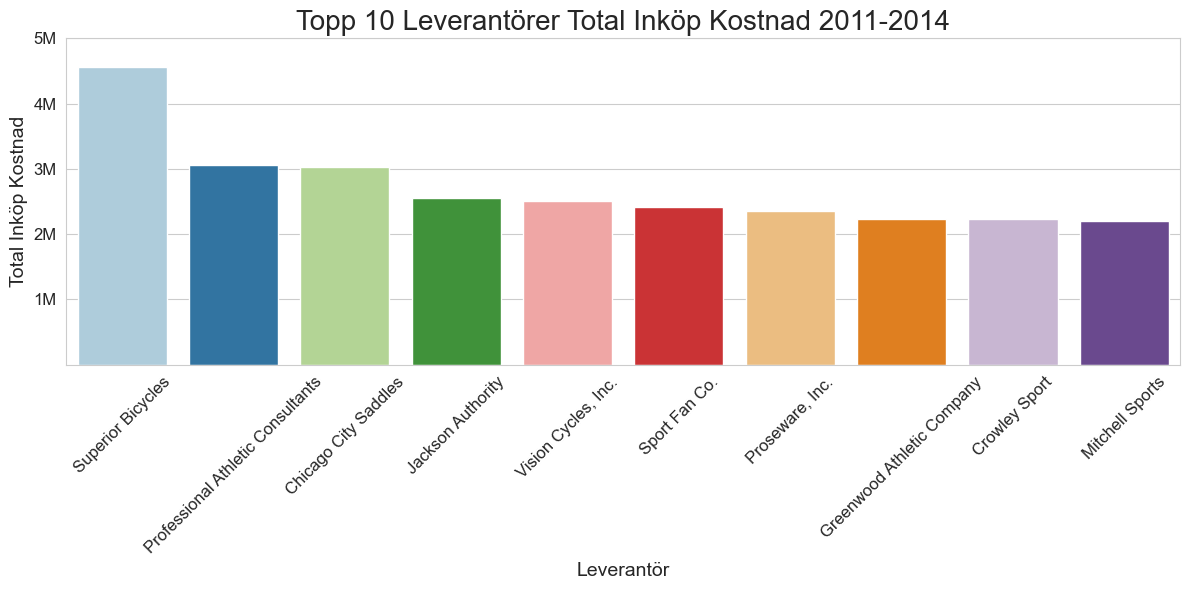

In [90]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Leverantör', y='Total Inköp Kostnad', data=InköpPerMånadToppLeverantör,\
            hue='Leverantör', palette='Paired')


plt.title('Topp 10 Leverantörer Total Inköp Kostnad 2011-2014', fontsize=20)

plt.xlabel('Leverantör', fontsize=14)
plt.xticks(fontsize=12, rotation=45)

plt.ylabel('Total Inköp Kostnad', fontsize=14)
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000], ['1M', '2M', '3M', '4M', '5M'], fontsize=12)

plt.tight_layout()
plt.show()

In [91]:
InköpPerMånadBottenLeverantör = """
    WITH LeverantörerOchKostnader 
    AS (
        SELECT 
            V.Name AS Leverantör
            , SUM(POD.LineTotal) AS [Total Inköp Kostnad]
            , AVG(POD.LineTotal) AS [Snitt Kostnad Per Order]
        FROM 
            Purchasing.PurchaseOrderHeader AS POH
                INNER JOIN Purchasing.PurchaseOrderDetail AS POD
                    ON POH.PurchaseOrderID = POD.PurchaseOrderID
            
                INNER JOIN Purchasing.Vendor AS V
                    ON POH.VendorID = V.BusinessEntityID
        GROUP BY 
            V.Name
    )

    SELECT Top (10) --PGA av ASC blir det botten 10
        Leverantör
        , [Total Inköp Kostnad]
        , [Snitt Kostnad Per Order]
    FROM LeverantörerOchKostnader
    ORDER BY 
        [Total Inköp Kostnad] ASC
    ;
"""
InköpPerMånadBottenLeverantör =pd.read_sql(InköpPerMånadBottenLeverantör,engine)
InköpPerMånadBottenLeverantör

,Leverantör,Total Inköp Kostnad,Snitt Kostnad Per Order
0,Northern Bike Travel,1853.7750,37.0755
1,Consumer Cycles,3057.1695,59.9445
2,G & K Bicycle Corp.,4578.3150,1526.1050
3,Lindell,4898.2500,48.9825
4,Burnett Road Warriors,5230.7640,102.5640
5,Metro Sport Equipment,5723.5500,114.4710
6,Wood Fitness,6287.4000,125.7480
7,"Midwest Sport, Inc.",6632.3250,132.6465
8,Wide World Importers,7262.9865,142.4115
9,International,7295.1165,143.0415


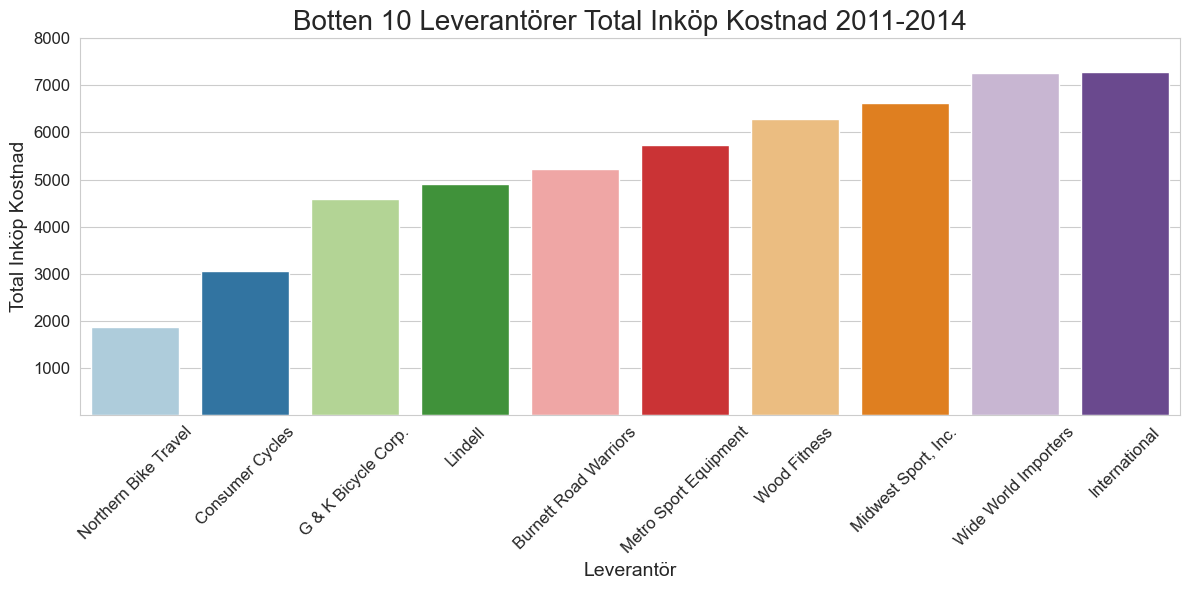

In [92]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Leverantör', y='Total Inköp Kostnad', data=InköpPerMånadBottenLeverantör,\
            hue='Leverantör', palette='Paired')


plt.title('Botten 10 Leverantörer Total Inköp Kostnad 2011-2014', fontsize=20)

plt.xlabel('Leverantör', fontsize=14)
plt.xticks(fontsize=12, rotation=45)

plt.ylabel('Total Inköp Kostnad', fontsize=14)
plt.yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000], [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000],fontsize=12)

plt.tight_layout()
plt.show()

In [93]:
#OBS inget riktigt leveranstid då leveransdatum är samma som datum produkten skickas eftersom 
# AdventureWorks är påhittat
Leveranstid = """
    SELECT 
        SalesOrderID
        , OrderDate AS [Order Date]
        , ShipDate AS [Leverans Datum]
        , DATEDIFF(day, OrderDate, ShipDate) AS [Leveranstid]
    FROM 
        Sales.SalesOrderHeader
    ;
"""
Leveranstid = pd.read_sql(Leveranstid, engine)
Leveranstid

,SalesOrderID,Order Date,Leverans Datum,Leveranstid
0,43659,2011-05-31,2011-06-07,7
1,43660,2011-05-31,2011-06-07,7
2,43661,2011-05-31,2011-06-07,7
3,43662,2011-05-31,2011-06-07,7
4,43663,2011-05-31,2011-06-07,7
...,...,...,...,...
31460,75119,2014-06-30,2014-07-07,7
31461,75120,2014-06-30,2014-07-07,7
31462,75121,2014-06-30,2014-07-07,7
31463,75122,2014-06-30,2014-07-07,7


In [94]:
FraktMetod = """
    SELECT 
        SM.ShipMethodID AS [Frakt ID]
        , SM.Name AS [Frakt Metod]
        , COUNT(SOH.SalesOrderID) AS [Antal Beställningar]
    FROM 
        Purchasing.ShipMethod AS SM
            LEFT JOIN Sales.SalesOrderHeader AS SOH
            ON SM.ShipMethodID = SOH.ShipMethodID
    GROUP BY 
        SM.ShipMethodID
        , SM.Name
    ;
"""
FraktMetod = pd.read_sql(FraktMetod, engine)
FraktMetod

,Frakt ID,Frakt Metod,Antal Beställningar
0,1,XRQ - TRUCK GROUND,27659
1,2,ZY - EXPRESS,0
2,3,OVERSEAS - DELUXE,0
3,4,OVERNIGHT J-FAST,0
4,5,CARGO TRANSPORT 5,3806


Text(0, 0.5, 'Antal Beställningar')

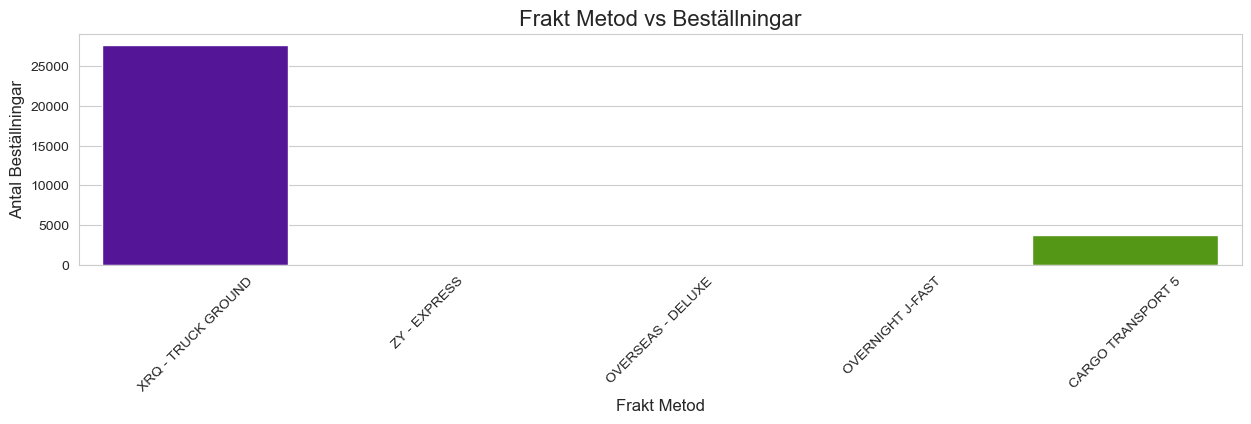

In [95]:
plt.figure(figsize=(15, 3))
sns.barplot(x='Frakt Metod', y='Antal Beställningar', data=FraktMetod, hue='Frakt Metod', palette='brg')


plt.title('Frakt Metod vs Beställningar', fontsize=16)

plt.xlabel('Frakt Metod', fontsize=12)
plt.xticks(fontsize=10, rotation=45)

plt.ylabel('Antal Beställningar', fontsize=12)

In [96]:
FraktKostnadMånad = """
    SELECT 
        YEAR(SOH.OrderDate) AS År
        , MONTH(SOH.OrderDate) AS Månad
        , SM.Name AS [Frakt Metod]
        , SUM(SOH.Freight) AS [Frakt Kostnader]
    FROM 
        Sales.SalesOrderHeader AS SOH
            INNER JOIN Purchasing.ShipMethod AS SM 
                ON SOH.ShipMethodID = SM.ShipMethodID
    GROUP BY 
        YEAR(SOH.OrderDate)
        , MONTH(SOH.OrderDate)
        , SM.Name
        , SM.Name 
    ORDER BY 
        YEAR(SOH.OrderDate)
        , MONTH(SOH.OrderDate)
        , SM.Name
    ;
"""
FraktKostnadMånad = pd.read_sql(FraktKostnadMånad, engine)
FraktKostnadMånad

,År,Månad,Frakt Metod,Frakt Kostnader
0,2011,5,CARGO TRANSPORT 5,14689.2647
1,2011,5,XRQ - TRUCK GROUND,361.9337
2,2011,6,XRQ - TRUCK GROUND,11472.7776
3,2011,7,CARGO TRANSPORT 5,46293.5105
4,2011,7,XRQ - TRUCK GROUND,12654.8000
...,...,...,...,...
67,2014,4,CARGO TRANSPORT 5,34.2425
68,2014,4,XRQ - TRUCK GROUND,44897.2779
69,2014,5,CARGO TRANSPORT 5,103483.9577
70,2014,5,XRQ - TRUCK GROUND,48779.9491


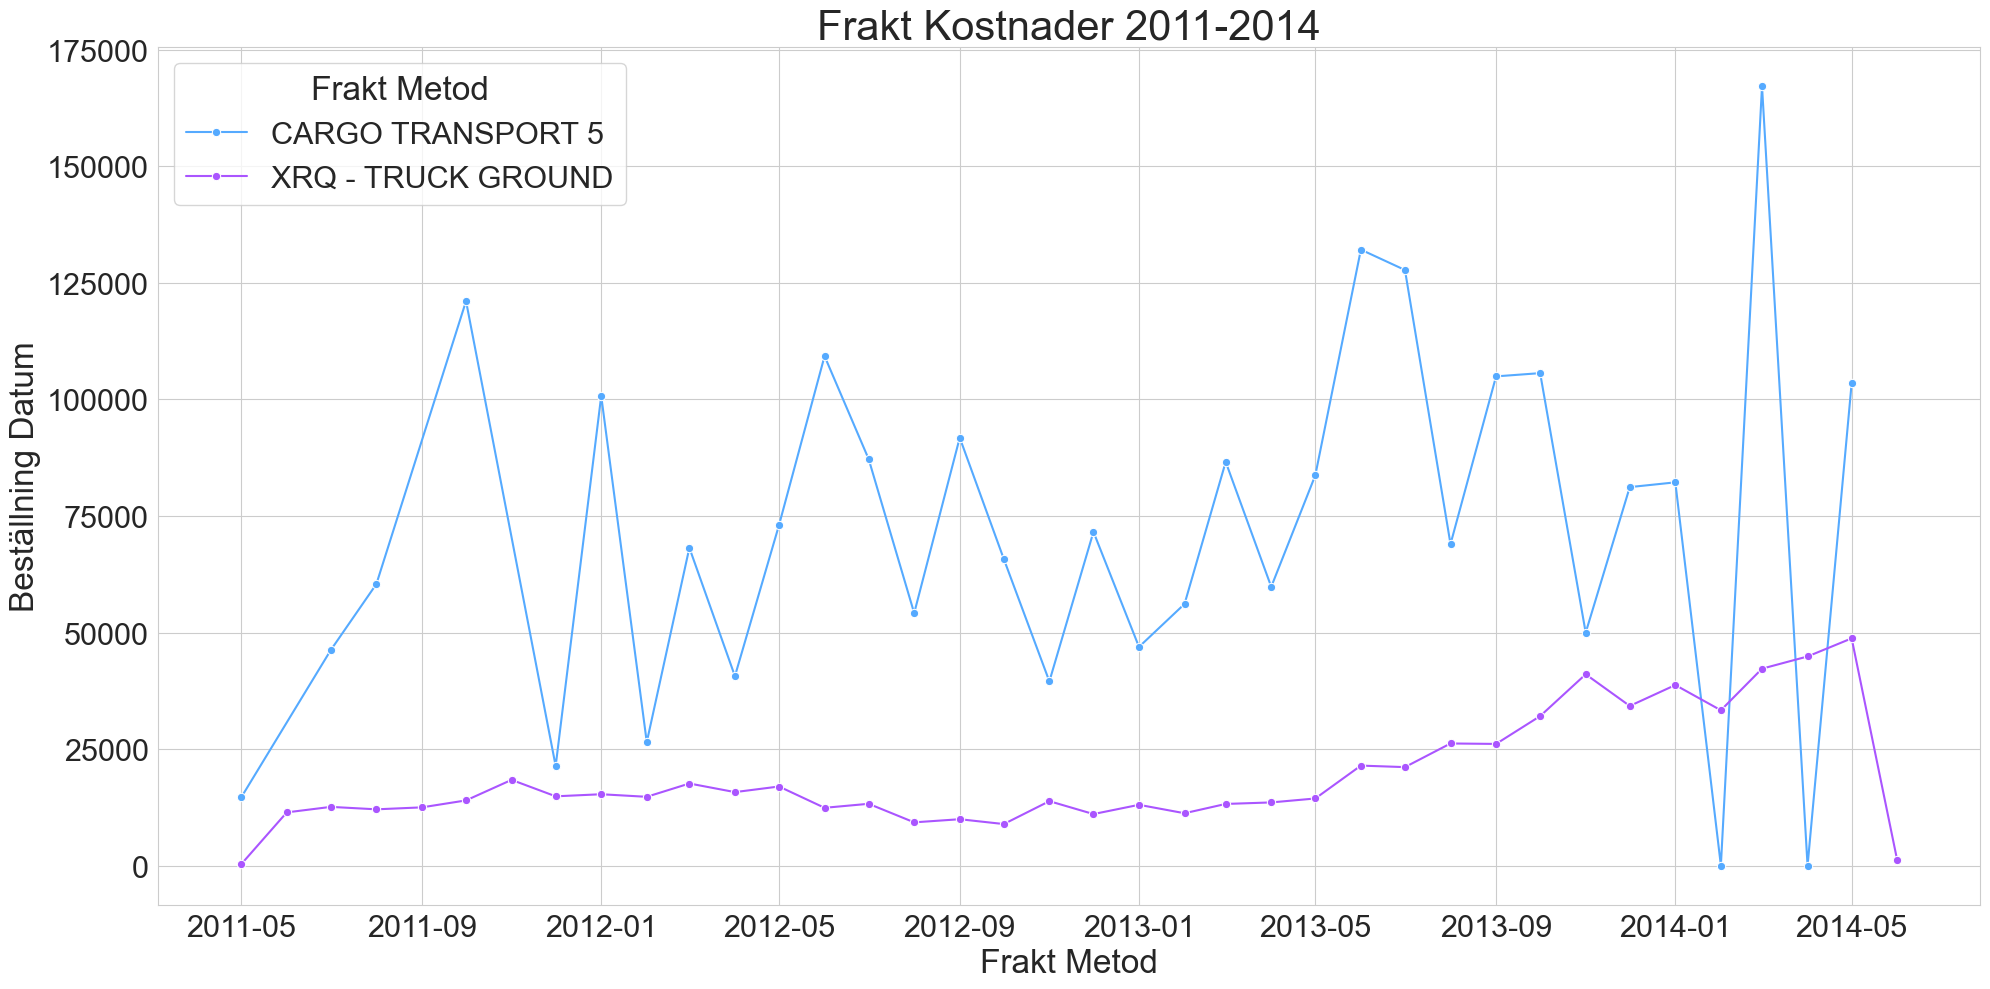

In [97]:
FraktKostnadMånad['Beställning Datum'] = pd.to_datetime(FraktKostnadMånad['År'].astype(str)\
                                        + '-' + FraktKostnadMånad['Månad'].astype(str))

plt.figure(figsize=(20, 10))
sns.lineplot(x='Beställning Datum', y='Frakt Kostnader', hue='Frakt Metod', data=FraktKostnadMånad,\
             marker='o', palette='cool')

plt.title('Frakt Kostnader 2011-2014', fontsize=30)

plt.xlabel('Frakt Metod', fontsize=24)
plt.xticks(fontsize=22)

plt.ylabel('Beställning Datum', fontsize= 24)
plt.yticks(fontsize=22)

plt.legend(title='Frakt Metod', title_fontsize=24, fontsize=22)

plt.tight_layout()
plt.grid(True)
plt.show()

## Slutresultat

In [98]:
Slutresultat = """
    WITH TotalInköp 
    AS (
        SELECT 
            YEAR(POH.OrderDate) AS År
            , MONTH(POH.OrderDate) AS Månad
            , SUM(POD.LineTotal) AS [Total Inköp]
        FROM 
            Purchasing.PurchaseOrderHeader AS POH
                INNER JOIN Purchasing.PurchaseOrderDetail AS POD
                    ON POH.PurchaseOrderID = POD.PurchaseOrderID
        GROUP BY 
            YEAR(POH.OrderDate)
            , MONTH(POH.OrderDate)
    ),

    TotalFraktKostnader_Inkomster AS (
        SELECT 
            YEAR(SOH.OrderDate) AS År
            , MONTH(SOH.OrderDate) AS Månad
            , SUM(SOH.Freight) AS [Total Frakt]
            , SUM(SOD.LineTotal) AS [Total Inkomst]
        FROM 
            Sales.SalesOrderHeader AS SOH
            INNER JOIN Sales.SalesOrderDetail AS SOD
                ON SOH.SalesOrderID = SOD.SalesOrderID
        GROUP BY 
            YEAR(SOH.OrderDate)
            , MONTH(SOH.OrderDate)
    )

    SELECT 
        TFI.År AS År
        , TFI.Månad AS Månad
        , COALESCE(TFIK.[Total Inkomst], 0) AS [Inkomst]
        , COALESCE(TFI.[Total Inköp], 0) AS [Total Inköp]
        , COALESCE(TFIK.[Total Frakt], 0) AS [Total Frakt]
        , COALESCE(TFIK.[Total Inkomst], 0) - COALESCE(TFI.[Total Inköp], 0) \
                                            - COALESCE(TFIK.[Total Frakt], 0) AS [Slutresultat]
    FROM 
        TotalInköp AS TFI
            LEFT JOIN TotalFraktKostnader_Inkomster AS TFIK
                ON TFI.År = TFIK.År AND TFI.Månad = TFIK.Månad
    ORDER BY 
        TFI.År
        , TFI.Månad     
    ;
"""
Slutresultat = pd.read_sql(Slutresultat, engine)
#TotalProfit = TotalProfit.fillna(0)
Slutresultat

,År,Månad,Inkomst,Total Inköp,Total Frakt,Slutresultat
0,2011,4,0.000000e+00,1.038958e+05,0.000000e+00,-1.038958e+05
1,2011,12,1.309863e+06,2.992400e+05,2.901621e+05,7.204611e+05
2,2012,1,3.970627e+06,7.004066e+05,1.528639e+06,1.741582e+06
3,2012,2,1.475427e+06,3.285725e+05,4.755866e+05,6.712679e+05
4,2012,3,2.975748e+06,6.469758e+05,1.311577e+06,1.017195e+06
5,2012,4,1.634601e+06,2.987451e+05,8.423690e+05,4.934867e+05
6,2012,5,3.074603e+06,2.506880e+05,3.223473e+06,-3.995585e+05
7,2012,6,4.099354e+06,5.112081e+05,4.540450e+06,-9.523036e+05
8,2012,7,3.417954e+06,1.603432e+05,3.794354e+06,-5.367434e+05
9,2012,8,2.175637e+06,4.549631e+05,2.016011e+06,-2.953369e+05


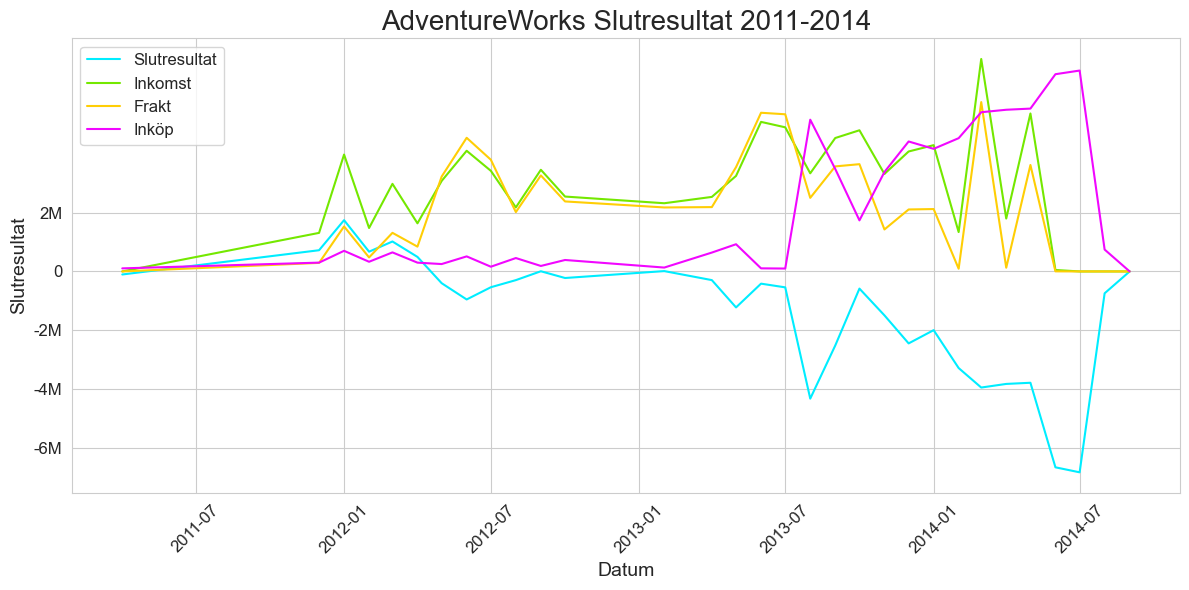

In [99]:

Slutresultat['Datum'] = pd.to_datetime(Slutresultat['År'].astype(str) + '-' \
                                                          + Slutresultat['Månad'].astype(str))

plt.figure(figsize=(12, 6))
colors = sns.color_palette('gist_ncar', n_colors=4)
sns.lineplot(x='Datum', y='Slutresultat', data=Slutresultat, label='Slutresultat', color=colors[0])
sns.lineplot(x='Datum', y='Inkomst', data=Slutresultat, label='Inkomst', color=colors[1])
sns.lineplot(x='Datum', y='Total Frakt', data=Slutresultat, label='Frakt', color=colors[2])
sns.lineplot(x='Datum', y='Total Inköp', data=Slutresultat, label='Inköp', color=colors[3])

plt.title('AdventureWorks Slutresultat 2011-2014', fontsize=20)

plt.xlabel('Datum', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.ylabel('Slutresultat', fontsize=14)
plt.yticks([-6000000, -4000000, -2000000, 0, 2000000], ['-6M', '-4M', '-2M', '0', '2M'], fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

